# Diffusion for Turkish Movies (Technical Report)

By Guanghui Pan, November 27, 2024. Corresponding to guanghui.pan@soicology.ox.ac.uk. 

This research aims to examine the diffusion process of Turkish dramas/movies. Turkish movies and shows are a compelling example of how cultural products can rapidly transcend national boundaries and resonate with global audiences, making them an ideal case study for understanding the mechanisms behind cultural diffusion.

**Technical Preparation**: the Python environment for this jupyter notebook is 3.12.7. The following packages are required to be installed before running:

In [ ]:
if False:
    !pip install pandas matplotlib numpy seaborn scikit-learn statsmodels scipy selenium requests bs4 warnings openai
    

And you need to download the latest version of chromedriver: https://developer.chrome.com/docs/chromedriver/downloads, install it in the selected folder (for instance, in this notebook, the location for chrome driver is __"C:/chromedriver/chromedriver.exe"__), and choose a useable API key for OpenAI: https://platform.openai.com/settings/.../api-keys. Version for selenium is 4.27.0; version for Chromedriver is 130.0.6723.69; and version for openai is 1.55.3. 

<div align="center"><strong>The approximate running time for this Jupyter Notebook is 6.5 hours.</strong></div>

## Data Preparation

### Get the Release Dates by Country

We originally got 300 movies/shows which are originated from Turkey from the website: https://www.turkishdrama.com/. Our goal here is to know the broadcast start date for every country. Fortunately, IMDB obtain the information on its realease dates in different countries. Here we give an example on the show "The Trailor (Terzi)":


Below is the original page for the movie, and its id is: tt15473010. Hence, the website is: https://imdb.com/title/tt15473010. 

![Original](original_page.png)

We here show the codes for matching the IMDB ID with its English name. 

In [38]:
if False: #unless you have the imdb dataset, do not run this cell
    import pandas as pd

    # Load the IMDb 'title.basics' dataset
    title_basics = pd.read_csv(
        'imdb/title.basics.tsv.gz',  # Adjust the path if necessary
        sep='\t',
        dtype=str,
        na_values='\\N',
        compression='gzip',
        low_memory=False  # Avoid dtype warnings
    )

    def get_imdb_urls(english_names):
        # Prepare a list to store results
        results = []

        # Convert 'primaryTitle' to lowercase for case-insensitive matching
        title_basics['primaryTitle_lower'] = title_basics['primaryTitle'].str.lower()

        # Filter for TV series to narrow down the search (optional)
        tv_series = title_basics[title_basics['titleType'] == 'tvSeries']

        # Iterate over each English name
        for name in english_names:
            name_lower = name.lower()
            # Search for exact matches in 'primaryTitle_lower'
            matches = tv_series[tv_series['primaryTitle_lower'] == name_lower]

            if not matches.empty:
                # If multiple matches, you might want to handle them accordingly
                # For simplicity, we'll take the first match
                row = matches.iloc[0]
                title_id = row['tconst']
                imdb_url = f"https://www.imdb.com/title/{title_id}/"
                results.append({
                    'English Title': name,
                    'IMDb URL': imdb_url
                })
            else:
                # Handle cases where no match is found
                results.append({
                    'English Title': name,
                    'IMDb URL': 'Not Found'
                })

        # Convert results to a DataFrame
        results_df = pd.DataFrame(results)
        return results_df

    # Example usage

    # Replace the following line with your actual DataFrame
    df_turkish_drama = pd.read_csv('turkish_drama_data.csv')

    # Extract the list of English names
    # Ensure 'English Title' is of string type and handle NaN values
    df_turkish_drama['English Title'] = df_turkish_drama['English Title'].astype(str)

    # Replace 'nan' strings with empty strings or a placeholder
    df_turkish_drama['English Title'].replace('nan', '', inplace=True)

    # Extract the list of English names
    english_names = df_turkish_drama['English Title'].tolist()
    # Get the IMDb URLs
    imdb_urls_df = get_imdb_urls(english_names)

    # Merge the IMDb URLs back to the original DataFrame
    df_turkish_drama = df_turkish_drama.merge(imdb_urls_df, on='English Title', how='left')

    # look at the updated DataFrame
    import re
    # Function to extract IMDb ID from URL
    def extract_imdb_id(url):
        match = re.search(r'(tt\d+)', url)
        if match:
            return match.group(1)
        else:
            return None

    # Apply the function to create a new 'IMDb ID' column
    df_turkish_drama['IMDb ID'] = df_turkish_drama['IMDb URL'].apply(extract_imdb_id)

    df_turkish_drama.rename(columns={'IMDb URL': 'IMDb URL from English', 'IMDb ID': 'IMDb ID from English'}, inplace=True)
    # write to csv:
    df_turkish_drama.to_csv('turkish_drama_data_with_imdb_eng.csv', index=False)

Then we try to match its IMDB ID with its Turkish name. 

In [39]:
if False: #unless you have the imdb dataset, do not run this cell
    # Replace the following line with your actual DataFrame
    df_turkish_drama = pd.read_csv('turkish_drama_data.csv')

    turkish_names = df_turkish_drama['Original Title'].dropna().astype(str).tolist()
    # Prepare a set of Turkish names for faster lookup
    turkish_names_set = set(name.lower() for name in turkish_names)

    # Prepare a list to collect matching records
    matching_records = []

    # Define the chunk size (adjust based on your system's memory capacity)
    chunksize = 100000  # You may adjust this number

    # Read 'title.akas.tsv.gz' in chunks
    for chunk in pd.read_csv('imdb/title.akas.tsv.gz', sep='\t', dtype=str, na_values='\\N',
                            compression='gzip', low_memory=False, chunksize=chunksize, encoding='utf-8'):
        # Ensure 'title' column is of string type and handle missing values
        chunk['title'] = chunk['title'].fillna('')
        chunk['title_lower'] = chunk['title'].str.lower()
        
        # Match Turkish names with the 'title' column
        matches = chunk[chunk['title_lower'].isin(turkish_names_set)]
        
        # Append matches to the list
        matching_records.append(matches[['titleId', 'title']])
    # Concatenate all matching records and remove duplicates
    matching_akas_df = pd.concat(matching_records).drop_duplicates()

    # Rename columns for clarity
    matching_akas_df.rename(columns={'titleId': 'IMDb ID', 'title': 'Original Title'}, inplace=True)

    matching_akas_df.head()
    # Remove duplicates in 'Original Title' if necessary
    matching_akas_df = matching_akas_df.drop_duplicates(subset=['Original Title'])

    # Merge with your original DataFrame
    df_turkish_drama = df_turkish_drama.merge(matching_akas_df, on='Original Title', how='left')

    # Construct IMDb URLs
    df_turkish_drama['IMDb URL from Turkish'] = 'https://www.imdb.com/title/' + df_turkish_drama['IMDb ID'] + '/'
    df_turkish_drama.rename(columns={'IMDb ID': 'IMDb ID from Turkish'}, inplace=True)

    # output the final DataFrame to a CSV file
    df_turkish_drama.to_csv('turkish_drama_data_with_imdb.csv', index=False)

So we first use the name to match in the IMDB database and find the correct IMDB ID. However, there are many shows with the same name, and so we matched the IMDB ID twice: once with its Turkish name, and the second with its English name. To make sure the movie/show is the correctly matched one, we check if the IMDB ID from Turkish is the same as the IMDB from English. If different, then we check separately on the original page for whether its country of origin is Turkey. If the country of origin can be matched, we then use the information from either Turkish or English IMDB to have the IMDB URL.

In [40]:
# merge the data for Turkish IMDB and English IMDB
import pandas as pd

turkish_imdb = pd.read_csv('turkish_drama_data_with_imdb.csv')  
english_imdb = pd.read_csv('turkish_drama_data_with_imdb_eng.csv')

In [41]:
# merge the two dataframes (append the columns of IMDb URL from English and IMDb ID from English to the Turkish dataframe, match with URL)
merged = pd.merge(turkish_imdb, english_imdb[['URL','IMDb URL from English', 'IMDb ID from English']], on='URL', how='left')
merged.head()

,URL,Original Title,English Title,Genre,Episodes,Broadcast Network,Broadcast Start Date,Broadcast End Date,Production Company,Director,Screen Writer,Synopsis,IMDb ID from Turkish,IMDb URL from Turkish,IMDb ID From Turkish,IMDb URL from English,IMDb ID from English
0,https://www.turkishdrama.com/the-tailor-terzi-...,Terzi,The Tailor,"Drama, Romance",23.0,Netflix,2-May-23,3-Nov-23,OGM Pictures,Cem Karci,NaN,Peyami Dokumaci (Cagatay Ulusoy) is a young an...,tt13317230,https://www.imdb.com/title/tt13317230/,tt13317230,https://www.imdb.com/title/tt15473010/,tt15473010
1,https://www.turkishdrama.com/sapphire-safir-tv...,Safir,Sapphire,"Romance, Drama",17.0,Atv,4-Sep-23,Present,NTC Medya,Semih Bagci,NaN,"Gulsoy family is a well-known, wealthy family ...",tt0821803,https://www.imdb.com/title/tt0821803/,tt0821803,https://www.imdb.com/title/tt17048670/,tt17048670
2,https://www.turkishdrama.com/omer-tv-series.html,Ömer,Omer,"Drama, Family",34.0,Star TV,9-Jan-23,present,OGM Pictures,Cem Karci,"Gulizar Irmak, Deniz Madanoglu, Sedef Bayburtl...",Omer (Selahattin Pasali) is a young guy in his...,tt22719788,https://www.imdb.com/title/tt22719788/,tt22719788,Not Found,NaN
3,https://www.turkishdrama.com/forevermore-verme...,Vermem Seni Ellere,Forevermore,"Romance, Drama",9.0,Atv,18-Jun-23,13-Aug-23,AKN Film,Ali Balci,"Sehrazat Tunus Tasci, Damla Gucer, Samed Aslan...",Mehmet (Emre Bey) is a young guy who comes fro...,tt27739128,https://www.imdb.com/title/tt27739128/,tt27739128,https://www.imdb.com/title/tt4183480/,tt4183480
4,https://www.turkishdrama.com/queen-kralice-tv-...,Kralice,Queen,"Drama, Romance",11.0,Kanal D,6-Apr-23,7-Jun-23,Mednova,"Cevdet Mercan, Serhan Sahin","Serdar Soydan, Kerem Bozok, Ekin Akcay, Nil Gu...",Deniz (Burcu Ozberk) and Ates (Gokhan Alkan) a...,NaN,NaN,NaN,https://www.imdb.com/title/tt11393148/,tt11393148


Have a function to check if the country of origin of the show is Turkey, and if so we use that information. 

In [42]:
import requests
from bs4 import BeautifulSoup

def is_country_of_origin_turkey(imdb_url):
    # if IMDB URL is a string and not start with 'https://www.imdb.com/title/'
    if not isinstance(imdb_url, str) or not imdb_url.startswith('https://www.imdb.com/title/'):
        return None
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(imdb_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the section containing country information
    country_section = soup.find('li', attrs={'data-testid': 'title-details-origin'})
    if not country_section:
        return None

    countries = country_section.find_all('a')
    country_list = [country.get_text(strip=True) for country in countries]

    if 'Turkey' in country_list:
        return imdb_url
    else:
        return None

# apply the function to the IMDb URL from English
merged['IMDb URL from English cleaned'] = merged['IMDb URL from English'].apply(is_country_of_origin_turkey)
merged['IMDb URL from Turkish cleaned'] = merged['IMDb URL from Turkish'].apply(is_country_of_origin_turkey)




In [43]:
# get the true URLs
def get_true_url(imdb_url_turkish, imdb_url_english):
    if imdb_url_turkish == imdb_url_english:
        return imdb_url_turkish
    elif imdb_url_turkish:
        return imdb_url_turkish
    elif imdb_url_english:
        return imdb_url_english
    else:
        return None

merged['IMDb URL'] = merged.apply(lambda x: get_true_url(x['IMDb URL from Turkish cleaned'], x['IMDb URL from English cleaned']), axis=1)

In [44]:
#check the true IMDB URLs
merged[merged['IMDb URL'].notnull()][['URL', 'IMDb URL', 'IMDb URL from Turkish cleaned', 'IMDb URL from English cleaned']].head()

,URL,IMDb URL,IMDb URL from Turkish cleaned,IMDb URL from English cleaned
0,https://www.turkishdrama.com/the-tailor-terzi-...,https://www.imdb.com/title/tt15473010/,None,https://www.imdb.com/title/tt15473010/
2,https://www.turkishdrama.com/omer-tv-series.html,https://www.imdb.com/title/tt22719788/,https://www.imdb.com/title/tt22719788/,None
3,https://www.turkishdrama.com/forevermore-verme...,https://www.imdb.com/title/tt27739128/,https://www.imdb.com/title/tt27739128/,None
5,https://www.turkishdrama.com/perfect-tenant-ku...,https://www.imdb.com/title/tt19383446/,https://www.imdb.com/title/tt19383446/,None
7,https://www.turkishdrama.com/farewell-letter-v...,https://www.imdb.com/title/tt24224504/,https://www.imdb.com/title/tt24224504/,https://www.imdb.com/title/tt24224504/


Finally, we get the release country and dates information from the page "releaseinfo". Here is the example of the releaseinfo for the Tailor, and the webpage is: https://imdb.com/title/tt15473010/releaseinfo:
![releaseinfo](releaseinfo.png)

We finally get the release countries information we want! But this is a dynamic webpage, as the release dates are stored in the dynamic table (as shown in the screenprint above). Hence, we use selenium to automatically click the "XX more" button and then get the release country and date information we want. 

In [ ]:
# after cleaning and found all the Turkish dramas, we then need to explore the release countries and release dates of the dramas 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import warnings
warnings.filterwarnings('ignore')


def get_countries_and_release_dates(imdb_url, driver=None):
    """
    Scrapes country and release date information from an IMDb release info page.

    Parameters:
        imdb_url (str): The IMDb release info URL.
        driver (webdriver.Chrome): An instance of Chrome WebDriver.

    Returns:
        dict: A dictionary containing the URL and extracted data.
    """
    import time
    
    if not isinstance(imdb_url, str) or not imdb_url.startswith('https://www.imdb.com/title/'):
        return None
    
    # If no driver is provided, initialize it
    driver_created = False
    if driver is None:
        from selenium import webdriver
        from selenium.webdriver.chrome.service import Service
        from selenium.webdriver.chrome.options import Options

        chrome_options = Options()
        chrome_options.add_argument("--headless")  # Run in headless mode
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36")
        service = Service('C:/chromedriver/chromedriver.exe')  # Update with your path
        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver_created = True
    
    imdb_url = imdb_url + 'releaseinfo'

    data = {'URL': imdb_url}

    try:
        driver.get(imdb_url)
        wait = WebDriverWait(driver, 20)

        # Handle the overlay if present
        overlay_locator = (By.CSS_SELECTOR, '.sc-kDvujY.kUNdqF')
        try:
            wait.until(EC.invisibility_of_element_located(overlay_locator))
        except:
            # Remove overlay via JavaScript if still present
            driver.execute_script("""
                var overlay = document.querySelector('.sc-kDvujY.kUNdqF');
                if (overlay) {
                    overlay.parentNode.removeChild(overlay);
                }
            """)

        # Locate and click the "See More" button if present
        try:
            button_locator = (By.CLASS_NAME, 'ipc-see-more__button')
            button = wait.until(EC.element_to_be_clickable(button_locator))
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", button)
            time.sleep(1)

            if button.is_displayed() and button.is_enabled():
                try:
                    button.click()
                except Exception:
                    driver.execute_script("arguments[0].click();", button)
        except Exception:
            pass  # No "See More" button found, proceed without clicking

        # Wait for the new content to load
        time.sleep(2)  # Adjust based on actual loading time

        # Locate all <li> elements with IDs starting with 'rel_'
        li_elements = driver.find_elements(By.XPATH, "//li[starts-with(@id, 'rel_')]")

        # Extract data from each <li> element
        for index, li in enumerate(li_elements, start=1):
            try:
                # Extract the ID
                li_id = li.get_attribute('id')

                # Extract the <a> element
                link = li.find_element(By.TAG_NAME, 'a')

                # Extract the country from the 'aria-label' attribute
                country = link.get_attribute('aria-label')

                # Extract the date from the specified <span> element
                date_element = li.find_element(By.CSS_SELECTOR, 'span.ipc-metadata-list-item__list-content-item')
                date_text = date_element.text

                # Add the data to the dictionary
                data[f'country{index}'] = country
                data[f'date{index}'] = date_text
            except Exception:
                continue  # Skip this li element and continue with the next one

    except Exception as e:
        print(f"An error occurred while processing {imdb_url}: {e}")

    finally:
        # Only quit the driver if it was created in this function
        if driver_created:
            driver.quit()

    return data

In [46]:
warnings.filterwarnings('ignore')
results = []

for url in merged['IMDb URL']:
    data = get_countries_and_release_dates(url, driver = None)
    results.append(data)




In [ ]:
filtered_results = [item for item in results if item is not None]
# Create DataFrame from filtered results
results_df = pd.DataFrame(filtered_results)
# back the URL to prepare for the merge with the original dataframe
results_df['URL'] = results_df['URL'].str.replace('releaseinfo', '')
results_df.head()
#merge results_df with the merged dataframe, left = merged[IMDb URL], right = results_df[URL]
final_df = pd.merge(merged, results_df, left_on='IMDb URL', right_on='URL', how='left')

def select_diffusion(df):
    return df[df['country1'].notnull()]

def rename(df):
    return df.rename(columns={'URL_x': 'URL'})

def drop_duplicates(df):
    return df.drop_duplicates(subset=['URL'], keep='first')

def pipe(data, *funcs):
    return reduce(lambda a, x: x(a), funcs, data)

from functools import reduce
final_df = pipe(final_df, select_diffusion, rename, drop_duplicates)
# final_df.to_csv('final.csv', index=False)


## EDA (exploratory data analysis)

Our first job is to check how many countries the drama has been shown, and give out a bar chart on the frequencies. 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
data = pd.read_csv('final.csv')

# we first need to clean the data (remove the duplicate countries and their dates)
country_cols = sorted([col for col in data.columns if col.startswith('country')],
                        key=lambda x: int(x.replace('country', '')))
date_cols = sorted([col for col in data.columns if col.startswith('date')],
                    key=lambda x: int(x.replace('date', '')))

# Function to process each row
def process_row(row):
    seen = set()
    for c_col, d_col in zip(country_cols, date_cols):
        country = row[c_col]
        if pd.isna(country):
            continue
        if country in seen:
            row[c_col] = None
            row[d_col] = None
        else:
            seen.add(country)
    return row

data = data.apply(process_row, axis=1)
# Apply the processing to each row
data.to_csv('final.csv', index=False)


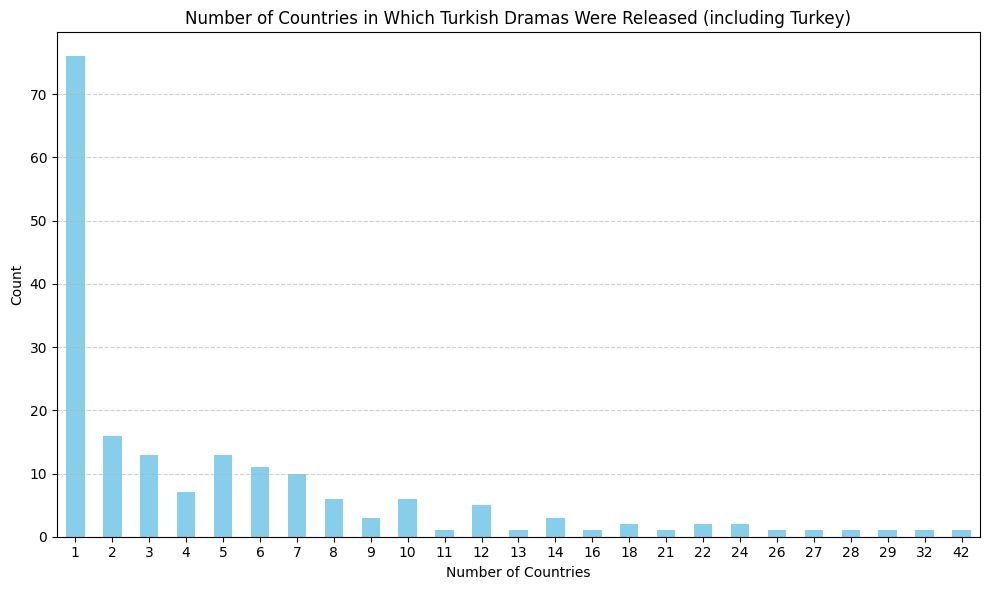

In [3]:
data = pd.read_csv('final.csv')
# count the number of countries
data['count_countries'] = data.filter(like='country').count(axis=1)
# output the bar chart


plt.figure(figsize=(10, 6))
data['count_countries'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Countries in Which Turkish Dramas Were Released (including Turkey)')
plt.xlabel('Number of Countries')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [4]:
data['count_countries'].value_counts().sum()

np.int64(185)

As can be shown in the plot, among the 185 dramas, more than 109 dramas have been introduced overseas.

Also, we need to plot how many Turkish dramas every country has introduced.

In [8]:
# Extract all country columns
country_columns = [col for col in data.columns if col.startswith('country')]

# Melt the dataframe to have a single column for countries
melted_df = data.melt(value_vars=country_columns, var_name='country_column', value_name='country')

# Drop NaN values
melted_df = melted_df.dropna(subset=['country'])
melt_df = melted_df[melted_df['country'] != 'Turkey']
# Count the occurrences of each country
country_counts = melted_df['country'].value_counts()
# count United States
country_counts['United States']

np.int64(23)

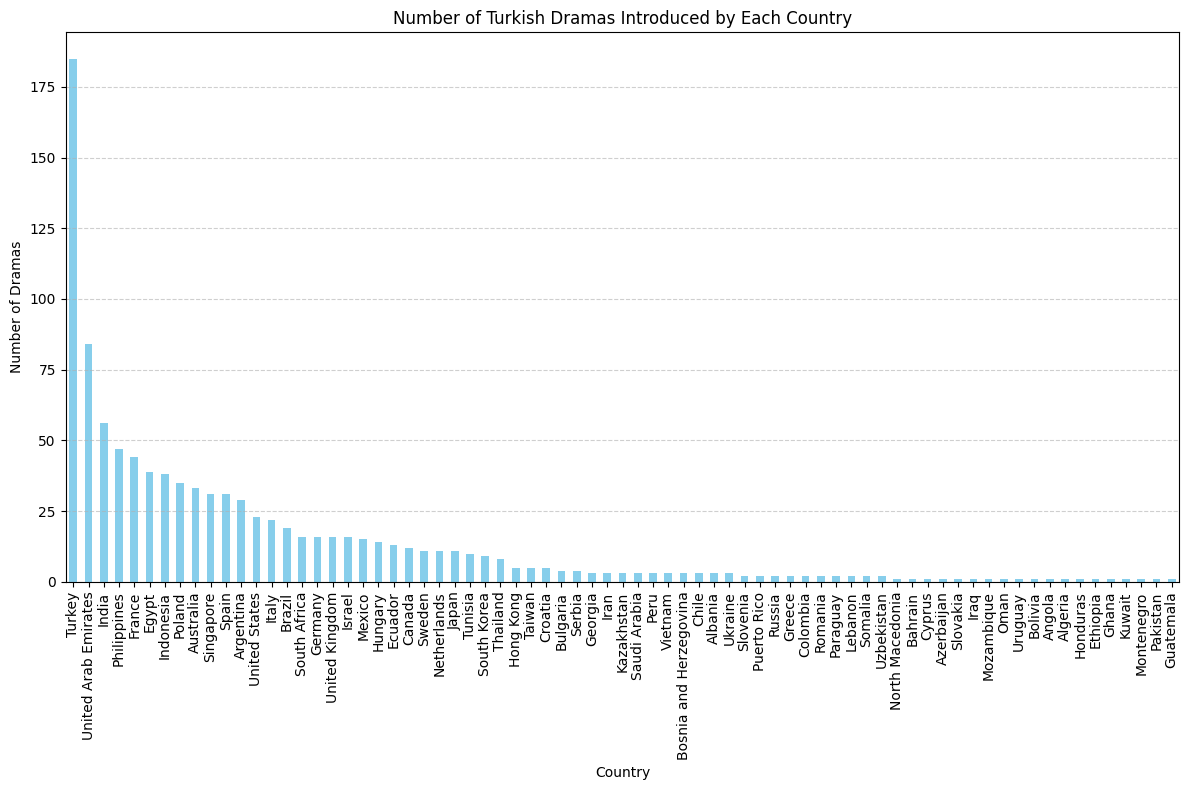

In [9]:
country_counts = melted_df['country'].value_counts()


# Plot the results
plt.figure(figsize=(12, 8))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Turkish Dramas Introduced by Each Country')
plt.xlabel('Country')
plt.ylabel('Number of Dramas')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

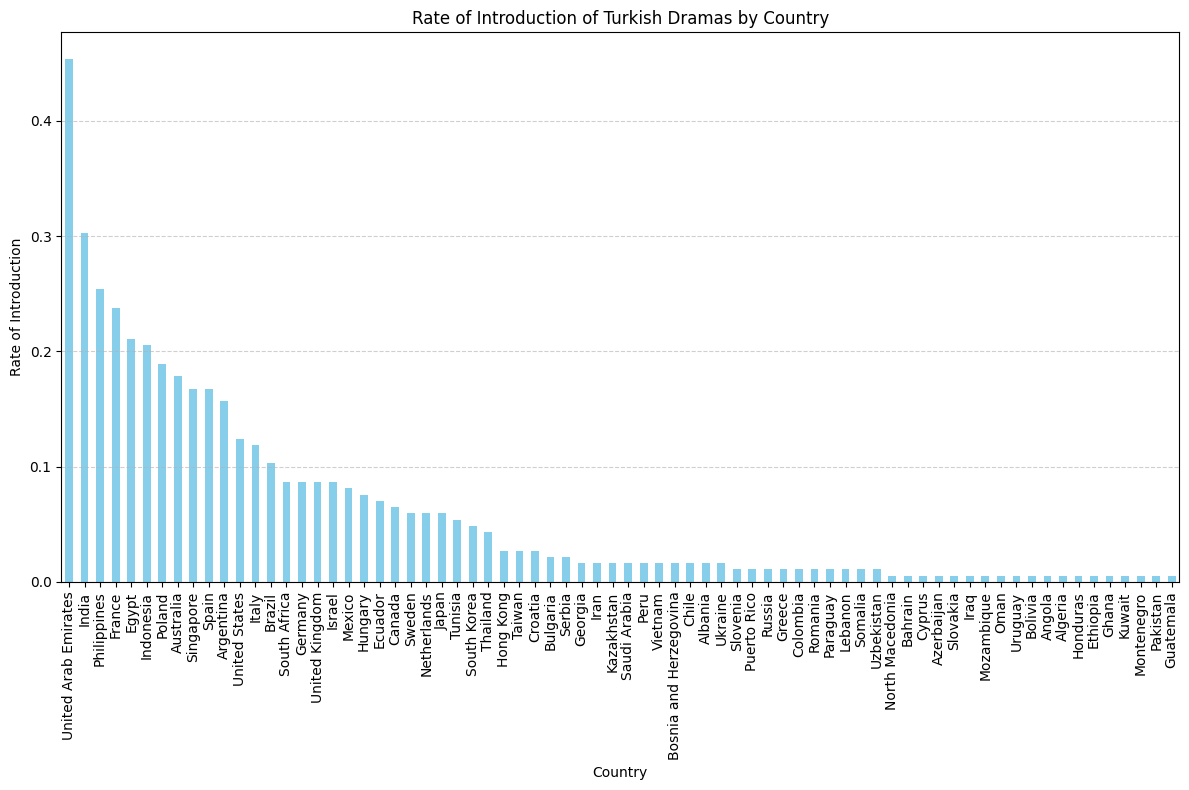

In [10]:
# for each country other than Turkey, find the rate of introduction of Turkish dramas
# Calculate the total number of Turkish dramas: nrows of the dataframe (excluding the header)
total_turkish_dramas  = data.shape[0]

# Calculate the number of Turkish dramas introduced by each country (excluding Turkey)
other_countries = country_counts.drop('Turkey')
# Calculate the rate of introduction for each country
rate_of_introduction = other_countries / total_turkish_dramas

# plot the bar chart
plt.figure(figsize=(12, 8))
rate_of_introduction.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Rate of Introduction of Turkish Dramas by Country')
plt.xlabel('Country')
plt.ylabel('Rate of Introduction')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### Dates differences

The second data exploration is the time difference between the initial broadcasting time in Turkey and the broadcasting time in other countries. We first transfer the release dates in every country into the days difference between the original release date and the release date.

In [11]:
import numpy as np
# assume the dates only with year was January 1st of that year
# Ensure the 'Broadcast Start Date' and date columns are in datetime format (if broadcasting start date is not available, use the date of the earliest release date among date1, date2, date3, etc.)
data['Broadcast Start Date'] = pd.to_datetime(data['Broadcast Start Date'], format = 'mixed', dayfirst= True, errors='coerce')
date_columns = [col for col in data.columns if col.startswith('date')]

# check the data type of the date columns
data[date_columns].dtypes
# Convert the date columns to datetime format
data[date_columns] = data[date_columns].apply(pd.to_datetime, format = 'mixed', dayfirst = True)

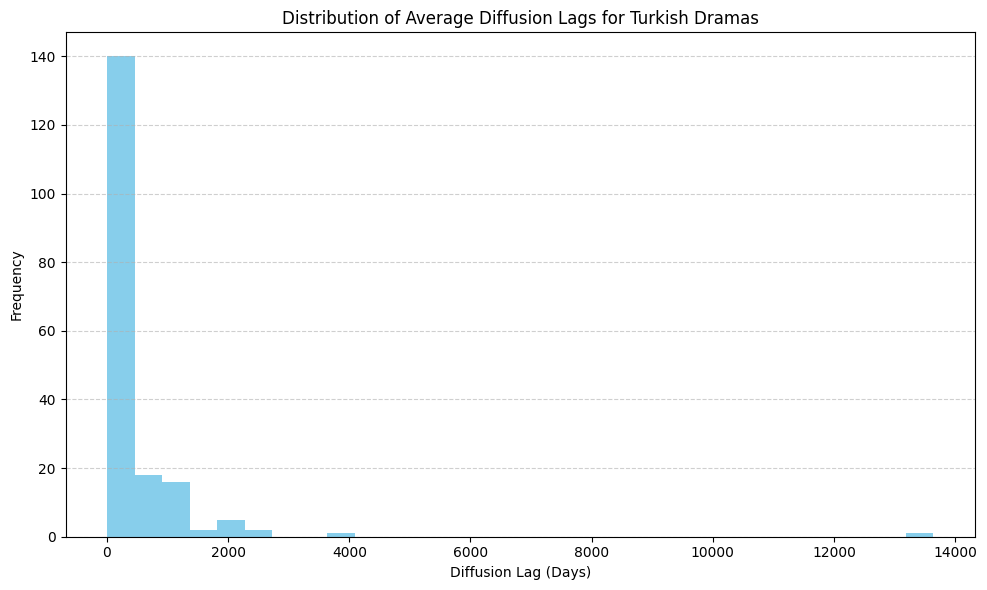

In [12]:
import warnings
warnings.filterwarnings('ignore')
data[date_columns] = data[date_columns].apply(lambda x: x.apply(lambda y: y.replace(day=1, month=1) if pd.notnull(y) and y.month == 1 else y))
data[date_columns] = data[date_columns].apply(pd.to_datetime, errors='coerce')
# if the date only has year, assume it is Jan 1st of that year

# Find the earliest release date among date1, date2, date3, etc.
data['Earliest Release Date'] = data[date_columns].min(axis=1)

# Fill missing 'Broadcast Start Date' with 'Earliest Release Date'
data['Broadcast Start Date'] = np.where(
    data['Broadcast Start Date'].isnull() | (data['Broadcast Start Date'] > data['Earliest Release Date']),
    data['Earliest Release Date'],
    data['Broadcast Start Date']
)


# Calculate the time difference between 'Broadcast Start Date' and release dates in each country
date_numbers = [int(col[4:]) for col in date_columns]
for num in date_numbers:
    data[f'diffusion lag {num}'] = data[f'date{num}'] - data['Broadcast Start Date'] 

# Calculate the average diffusion lag
data['Average Diffusion Lag'] = data[[f'diffusion lag {num}' for num in date_numbers]].mean(axis=1)

# Plot the distribution of average diffusion lags
plt.figure(figsize=(10, 6))
data['Average Diffusion Lag'].dt.days.plot(kind='hist', bins=30, color='skyblue')
plt.title('Distribution of Average Diffusion Lags for Turkish Dramas')
plt.xlabel('Diffusion Lag (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


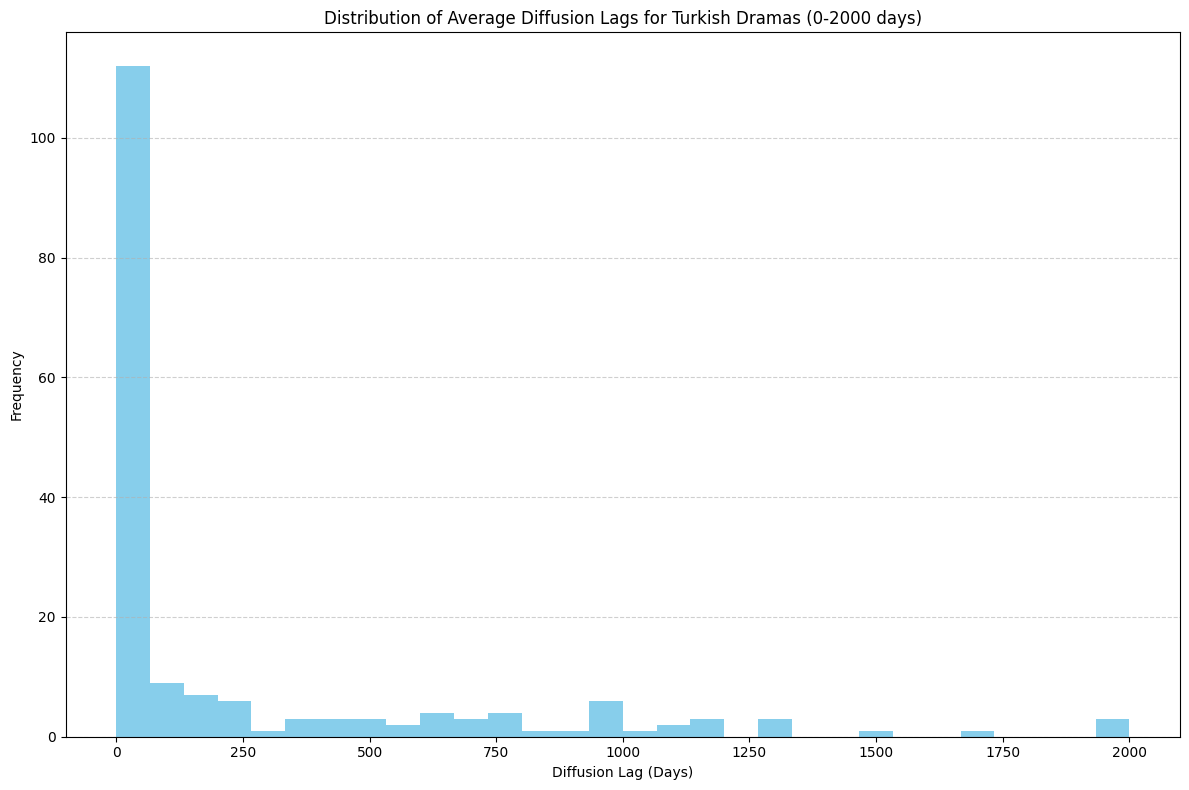

In [13]:
# plot if the lag is more than 0 and less than 2000
plt.figure(figsize=(12, 8))
data['Average Diffusion Lag'].dt.days.plot(kind='hist', bins=30, color='skyblue', range=(0, 2000))
plt.title('Distribution of Average Diffusion Lags for Turkish Dramas (0-2000 days)')
plt.xlabel('Diffusion Lag (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

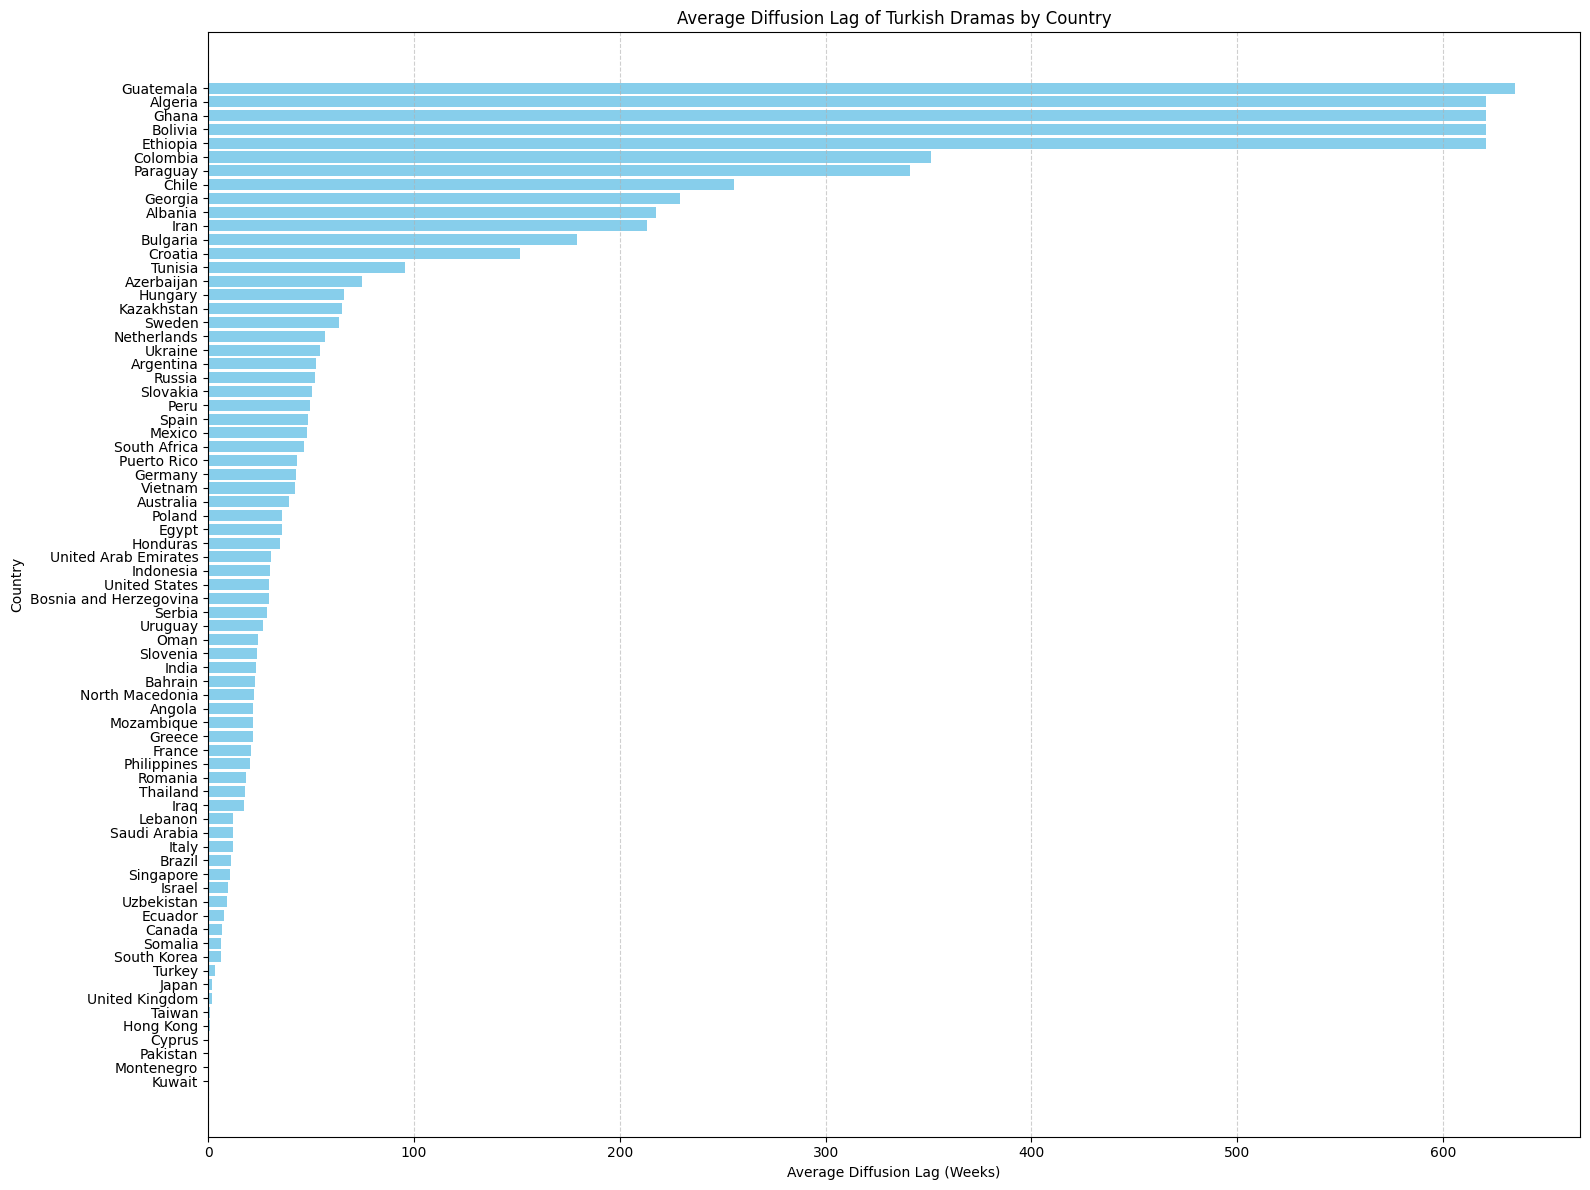

In [14]:
# plot the diffusion lag for each country
# melt the data first 
import re
pattern = re.compile(r'country(\d+)')
country_numbers = [pattern.match(col).group(1) for col in data.columns if pattern.match(col)]

data_long = pd.DataFrame()

for num in country_numbers:
    country_col = f'country{num}'
    lag_col = f'diffusion lag {num}'
    temp = data[[country_col, lag_col]].copy()
    temp.columns = ['country', 'diffusion lag']
    data_long = pd.concat([data_long, temp], ignore_index=True)

# Clean data
data_long.dropna(subset=['country', 'diffusion lag'], inplace=True)

# Plot the diffusion lag for each country
average_diffusion_lag = (
    data_long
    .groupby('country')['diffusion lag']
    .mean()
    .reset_index()
    .rename(columns={'diffusion lag': 'Average Diffusion Lag'})
    .sort_values('Average Diffusion Lag', ascending=True)
)

# transfer days into months
average_diffusion_lag['Average Diffusion Lag'] = average_diffusion_lag['Average Diffusion Lag'].dt.days / 30

# plot the average diffusion lag for each country
plt.figure(figsize=(16, 12))
plt.barh(average_diffusion_lag['country'], average_diffusion_lag['Average Diffusion Lag'], color='skyblue')
plt.title('Average Diffusion Lag of Turkish Dramas by Country')
plt.xlabel('Average Diffusion Lag (Weeks)')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Finally, we generate teh country-centered database to show how many Turkish dramas/shows/movies have been introuced to that country. 

In [15]:
country_data = pd.DataFrame(melted_df['country'].value_counts()).reset_index()
country_data.columns = ['country', 'number of Turkish dramas']

In [19]:
# to automatically get which country in which continent, we need the pycountry library
#!pip install pycountry pycountry-convert

import pycountry_convert as pc
import pycountry
def country_to_continent(country_name):
    try:
        # Lookup the country by name to get the alpha_2 code
        country = pycountry.countries.lookup(country_name)
        country_code = country.alpha_2
        # Map the alpha_2 code to a continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Convert the continent code to continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except Exception as e:
        # Handle exceptions (e.g., country not found)
        return None
country_data['continent'] = country_data['country'].apply(country_to_continent)
country_data['country'].unique()

array(['Turkey', 'United Arab Emirates', 'India', 'Philippines', 'France',
       'Egypt', 'Indonesia', 'Poland', 'Australia', 'Singapore', 'Spain',
       'Argentina', 'United States', 'Italy', 'Brazil', 'South Africa',
       'Germany', 'United Kingdom', 'Israel', 'Mexico', 'Hungary',
       'Ecuador', 'Canada', 'Sweden', 'Netherlands', 'Japan', 'Tunisia',
       'South Korea', 'Thailand', 'Hong Kong', 'Taiwan', 'Croatia',
       'Bulgaria', 'Serbia', 'Georgia', 'Iran', 'Kazakhstan',
       'Saudi Arabia', 'Peru', 'Vietnam', 'Bosnia and Herzegovina',
       'Chile', 'Albania', 'Ukraine', 'Slovenia', 'Puerto Rico', 'Russia',
       'Greece', 'Colombia', 'Romania', 'Paraguay', 'Lebanon', 'Somalia',
       'Uzbekistan', 'North Macedonia', 'Bahrain', 'Cyprus', 'Azerbaijan',
       'Slovakia', 'Iraq', 'Mozambique', 'Oman', 'Uruguay', 'Bolivia',
       'Angola', 'Algeria', 'Honduras', 'Ethiopia', 'Ghana', 'Kuwait',
       'Montenegro', 'Pakistan', 'Guatemala'], dtype=object)

In [22]:
# draw the map based on the country data
#!pip install geopandas
#!pip install geodatasets
import geopandas as gpd
import geodatasets as gds
# Load the world map
url = 'https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson'

# Load the dataset
world = gpd.read_file(url)

# look up the world data
world.head()
# full list of world ADMIN
world['ADMIN'].unique()
# change the specific names
world.replace('United States of America', 'United States', inplace=True)


In [23]:

# Merge the world map with the country data
world = world.merge(country_data, left_on='ADMIN', right_on='country', how='left')
# show the cases that merge failed
world[world['ADMIN'].isnull()]['country'].unique()

array([], dtype=object)

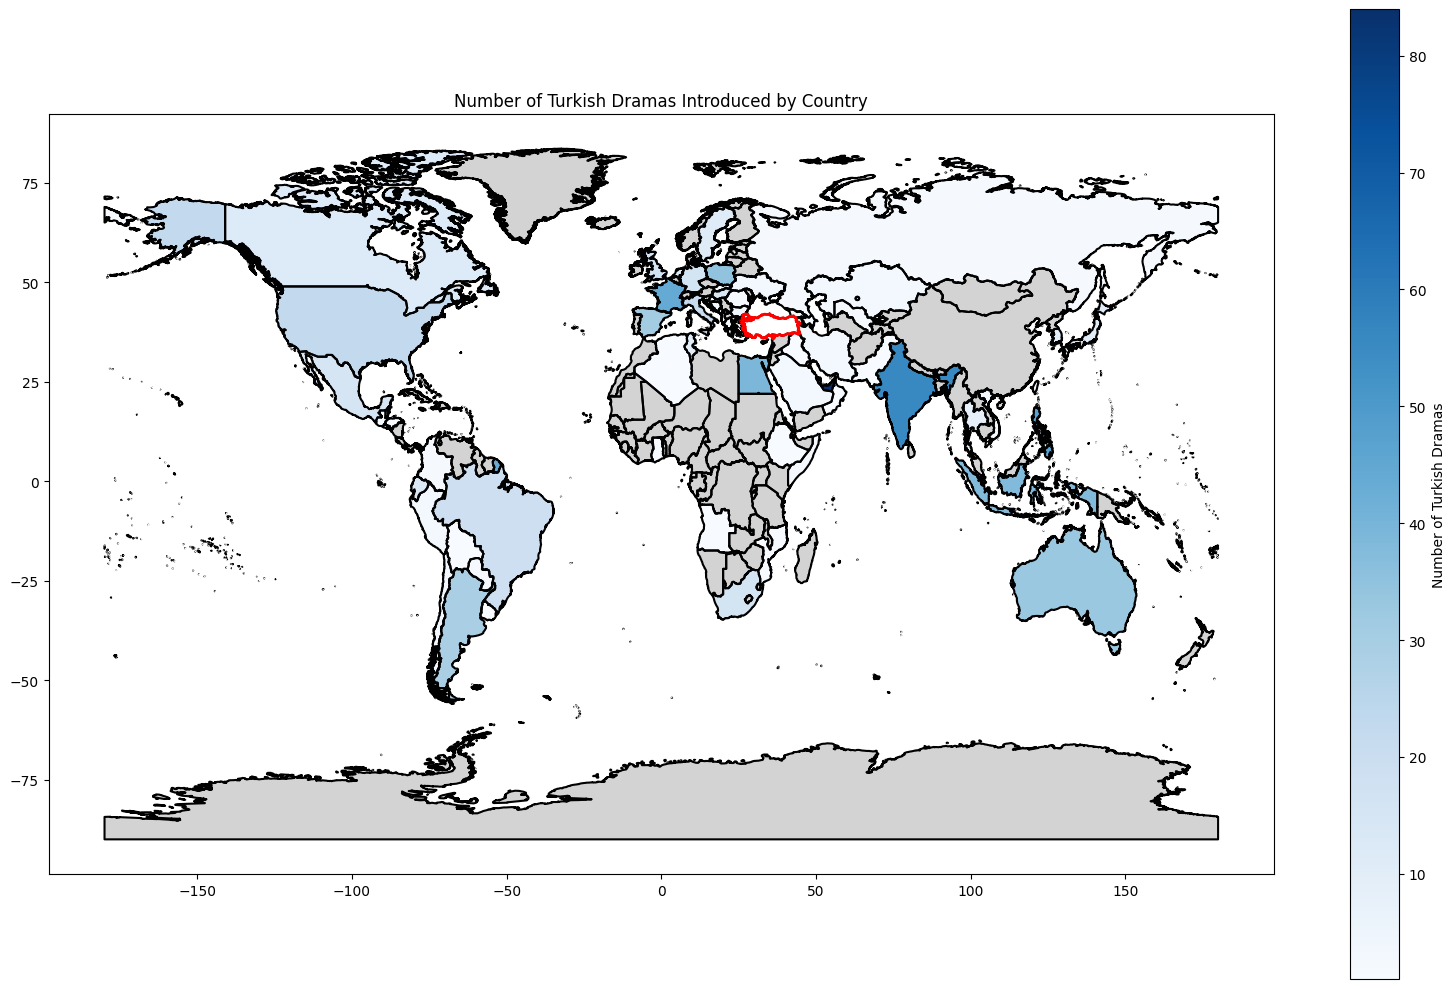

In [24]:


turkey = world[world['ADMIN'] == 'Turkey']
other_countries = world[world['ADMIN'] != 'Turkey']
# Plot the world map

fig, ax = plt.subplots(figsize=(16, 10))
world.boundary.plot(ax=ax, color='black')

# Plot other countries with shades of blue
other_countries.plot(
    column='number of Turkish dramas',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Number of Turkish Dramas"},
    cmap='Blues',
    missing_kwds={'color': 'lightgrey'}
)

# Highlight Turkey in red
turkey.boundary.plot(ax=ax, color='red', linewidth=2)

plt.title('Number of Turkish Dramas Introduced by Country')
plt.tight_layout()
plt.show()


### Relationship between geographic distance, cultural distance, and number of dramas

We measure the geographic distance by the capitals of countries to Ankara (the capital of Turkey). Data source: https://www.naturalearthdata.com/downloads/. 
We get the cultural distance from one country to Turkey from the World Value Survey (WVS). In the WVS, they assert two major dimensions of cross cultural variation in the world: traditional values versus secular-rational values and survival values versus self-expression values (see https://www.worldvaluessurvey.org/WVSNewsShow.jsp?ID=467). Based on their outputs, we standardize the dimensions and output the standardized cultural distance to Turkey for each country (Turkey to Turkey is 0 and most divergent country Sweden is coded as 1). 

In [167]:
capitals = pd.read_csv('capitals.csv')
# Merge the capital cities with the country data
country_data_merged = country_data.merge(capitals, on='country', how='left')

def distance_to_ankara(lat, lon):
    ankara_lat, ankara_lon = 39.9199, 32.8543
    distance =  np.sqrt((lat - ankara_lat) ** 2 + (lon - ankara_lon) ** 2)
    std_distance = (distance - distance.min()) / (distance.max() - distance.min())
    return std_distance

country_data_merged['distance_to_ankara'] = distance_to_ankara(country_data_merged['Latitude'], country_data_merged['Longitude'])


country_data_merged.head()

,country,number of Turkish dramas,continent,Capital City,Latitude,Longitude,Population,Capital Type,distance_to_ankara
0,Turkey,185,None,Ankara,39.9199,32.8543,4919074,Capital,0.000000
1,United Arab Emirates,84,Asia,Abu Zaby (Abu Dhabi),24.4648,54.3618,1419699,Capital,0.191260
2,India,56,Asia,Delhi,28.6667,77.2167,28513682,Capital,0.330512
3,Philippines,47,Asia,Manila,14.6042,120.9822,13482468,Capital,0.662158
4,France,44,Europe,Paris,48.8534,2.3488,10900952,Capital,0.229549


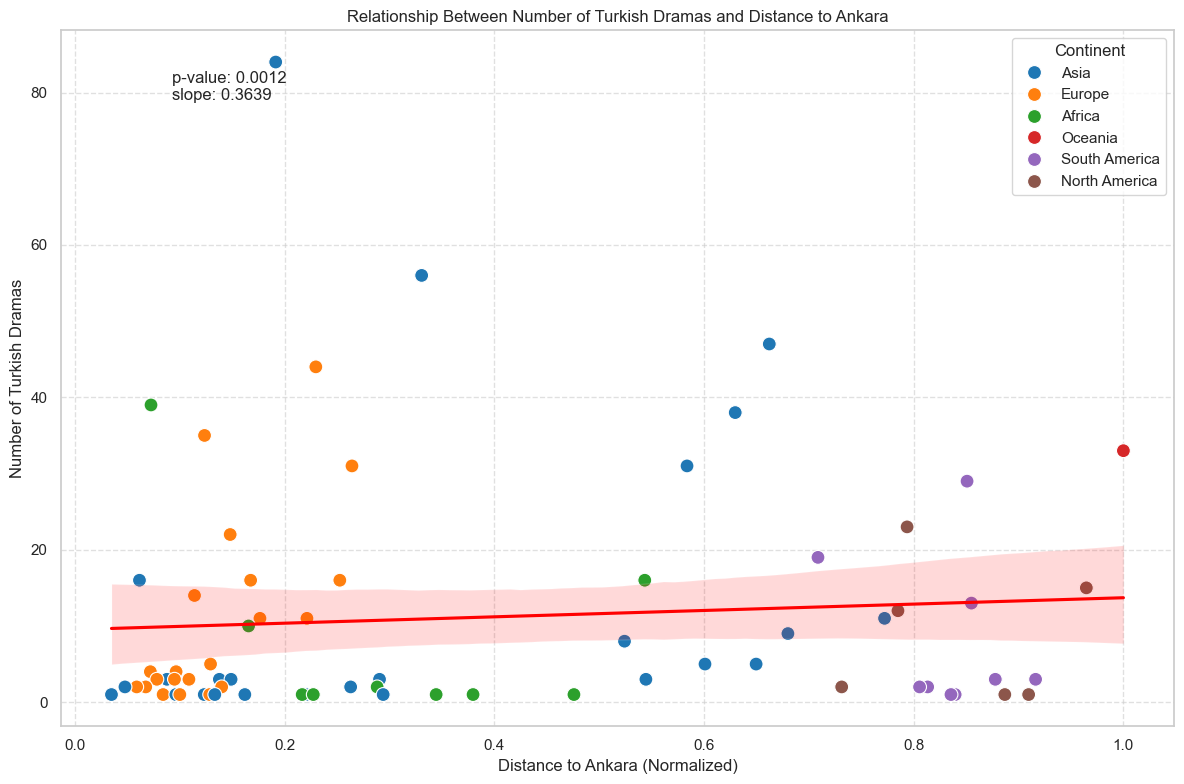

In [168]:
# plot the relationship between number of Turkish dramas and distance to Ankara (scatter plot + regression line w/ confidence interval, note the R-squared value and slope)
#exclude turkey
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm

country_data_merged_no_turkey = country_data_merged[country_data_merged['country'] != 'Turkey']
country_data_merged_no_turkey['rate of introduction'] = country_data_merged_no_turkey['number of Turkish dramas'] / country_data_merged[country_data_merged['country'] == 'Turkey']['number of Turkish dramas'].values[0]
# drop na values
natural_distance = country_data_merged_no_turkey.dropna(subset=['number of Turkish dramas', 'distance_to_ankara'])

# Perform Poisson regression and get the slope and p-value
poisson_model = sm.GLM(natural_distance['number of Turkish dramas'], sm.add_constant(natural_distance['distance_to_ankara']), family=sm.families.Poisson()).fit()
slope = poisson_model.params['distance_to_ankara']
p_value = poisson_model.pvalues['distance_to_ankara']


# Plot the scatter plot and the regression line (for each country, group by continent in the scatter plot)
plt.figure(figsize=(12, 8))
# Scatter plot with points colored by continent
sns.scatterplot(
    x='distance_to_ankara',
    y='number of Turkish dramas',
    data=natural_distance,
    hue='continent',
    palette='tab10',
    s=100,
    edgecolor='white'
)

# Add regression line without scatter points
sns.regplot(
    x='distance_to_ankara',
    y='number of Turkish dramas',
    data=natural_distance,
    scatter=False,
    color='red',
    line_kws={'label': f"Linear fit (p-value: {p_value:.4f}, Slope: {slope:.4f})"}
)

# Formatting the plot
plt.title('Relationship Between Number of Turkish Dramas and Distance to Ankara')
plt.xlabel('Distance to Ankara (Normalized)')
plt.ylabel('Number of Turkish Dramas')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.text(0.1, 0.9, f'p-value: {p_value:.4f}\nslope: {slope:.4f}', transform=plt.gca().transAxes)

plt.legend(title='Continent')

plt.tight_layout()
plt.show()

In [169]:
cultural_distance = pd.read_csv('distance_to_tr_2024Nov_simple.csv')

# merge the cultural distance with the country data
country_data_merged_cultural = country_data_merged.merge(cultural_distance, on='country', how='left')
country_data_merged_cultural['rate of introduction'] = country_data_merged_cultural['number of Turkish dramas'] / total_turkish_dramas
# rename the column "std_dist_to_TR" to "cultural distance"
country_data_merged_cultural.rename(columns={'std_dist_to_TR': 'cultural distance'}, inplace=True)
#drop Turkey and the NA values
country_data_merged_cultural_no_turkey = country_data_merged_cultural[country_data_merged_cultural['country'] != 'Turkey']
country_data_merged_cultural_no_turkey = country_data_merged_cultural_no_turkey.dropna(subset=['number of Turkish dramas', 'cultural distance'])

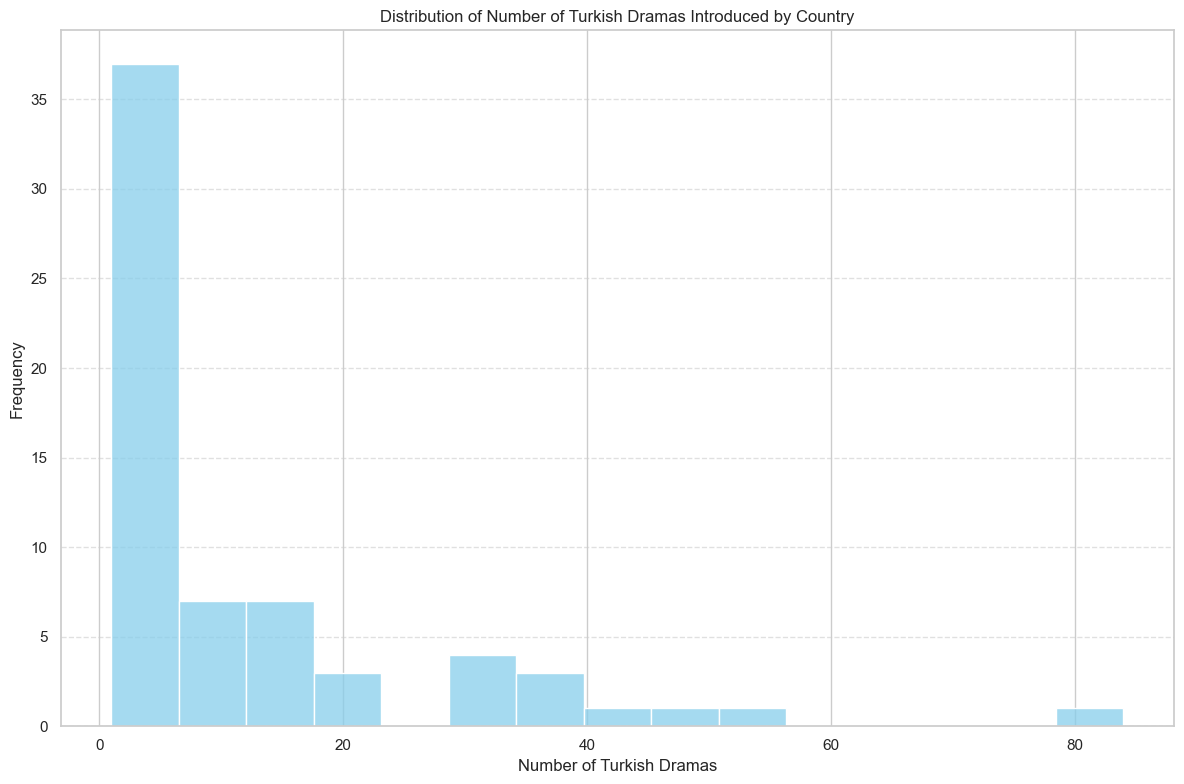

In [170]:
# examine the distribution of number of Turkish dramas
plt.figure(figsize=(12, 8))
sns.histplot(country_data_merged_cultural_no_turkey['number of Turkish dramas'], bins=15, color='skyblue')
plt.title('Distribution of Number of Turkish Dramas Introduced by Country')
plt.xlabel('Number of Turkish Dramas')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


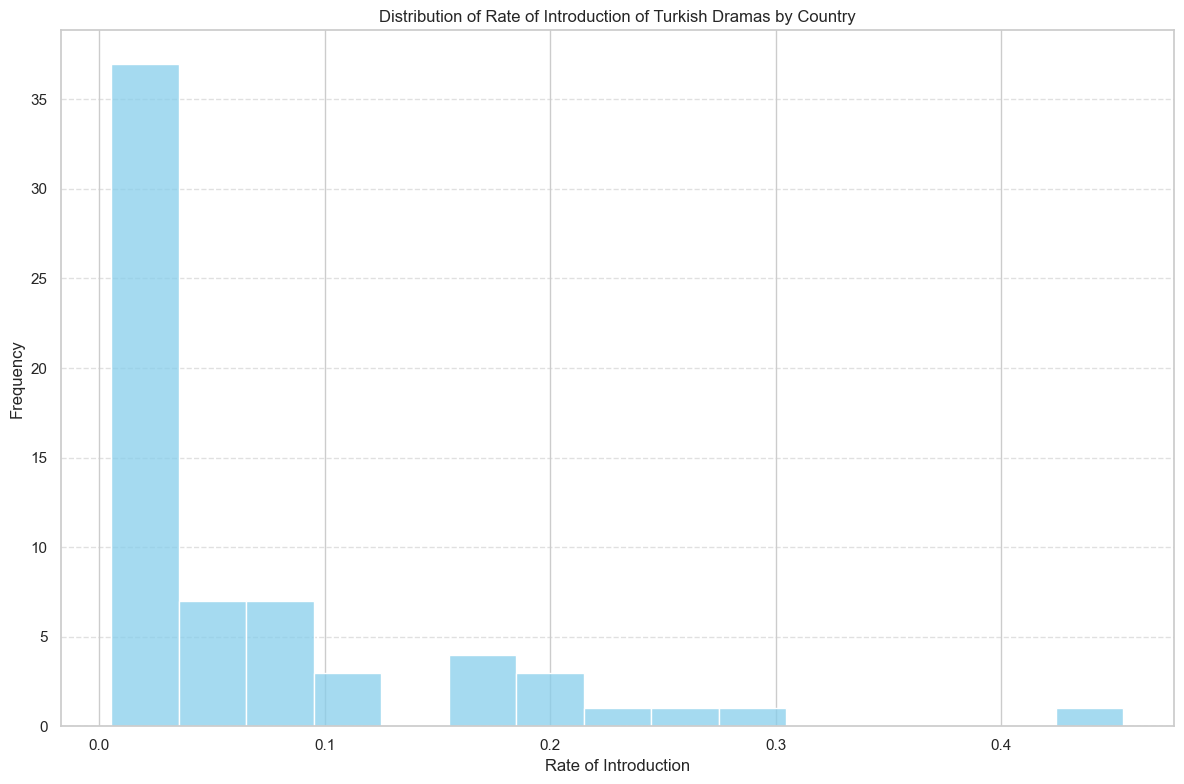

In [172]:
# Distribution for rate of introduction
plt.figure(figsize=(12, 8))
sns.histplot(country_data_merged_cultural_no_turkey['rate of introduction'], bins=15, color='skyblue')
plt.title('Distribution of Rate of Introduction of Turkish Dramas by Country')
plt.xlabel('Rate of Introduction')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


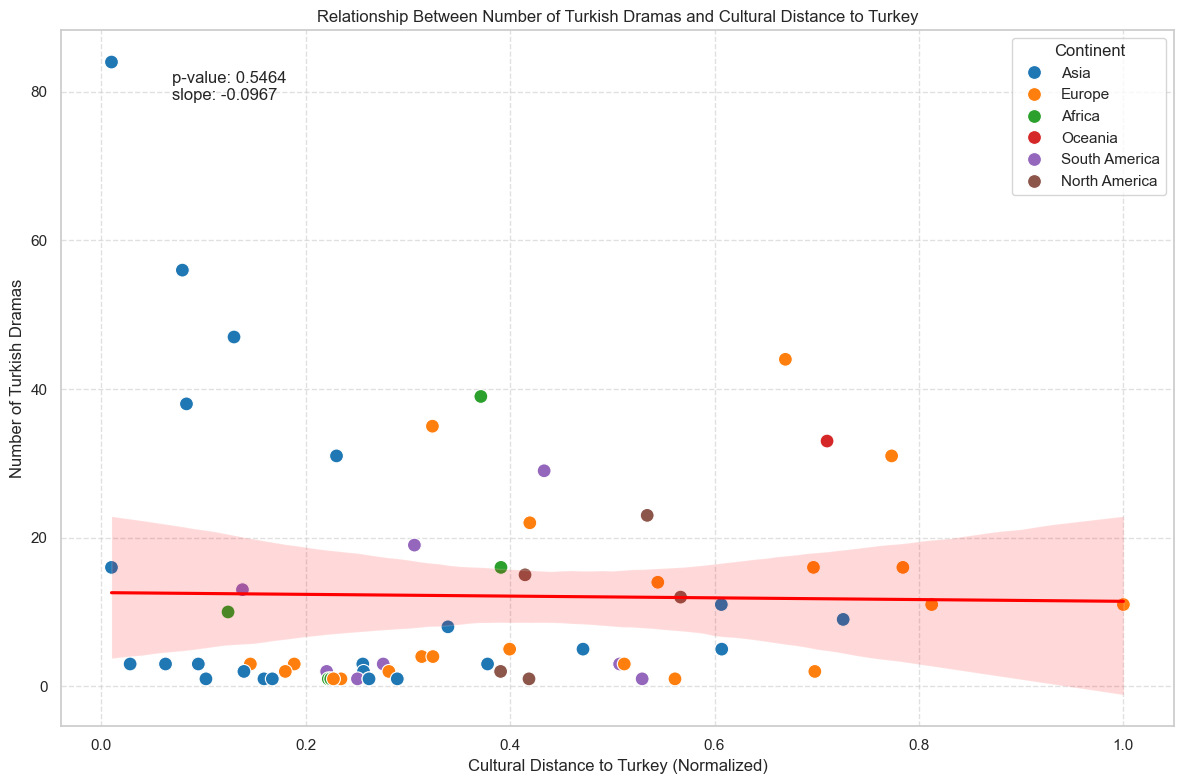

In [173]:
#similar to the previous plot, plot the relationship between number of Turkish dramas and cultural distance
# Perform poisson regression and get the slope and p-value
poisson_model = sm.GLM(country_data_merged_cultural_no_turkey['number of Turkish dramas'], sm.add_constant(country_data_merged_cultural_no_turkey['cultural distance']), family=sm.families.Poisson()).fit()
slope = poisson_model.params['cultural distance']
p_value = poisson_model.pvalues['cultural distance']

# Plot the scatter plot and the regression line
plt.figure(figsize=(12, 8))
# Scatter plot with points colored by continent
sns.scatterplot(
    x='cultural distance',
    y='number of Turkish dramas',
    data=country_data_merged_cultural_no_turkey,
    hue='continent',
    palette='tab10',
    s=100,
    edgecolor='white'
)

# Add regression line without scatter points
sns.regplot(
    x='cultural distance',
    y='number of Turkish dramas',
    data=country_data_merged_cultural_no_turkey,
    scatter=False,
    color='red',
    line_kws={'label': f"Linear fit (p-value: {p_value:.4f}, Slope: {slope:.4f})"}
)

# Formatting the plot
plt.title('Relationship Between Number of Turkish Dramas and Cultural Distance to Turkey')
plt.xlabel('Cultural Distance to Turkey (Normalized)')
plt.ylabel('Number of Turkish Dramas')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.text(0.1, 0.9, f'p-value: {p_value:.4f}\nslope: {slope:.4f}', transform=plt.gca().transAxes)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()



In [174]:
# save the data to a csv file
country_data_merged_cultural_no_turkey.to_csv('country_data_merged_cultural.csv', index=False)

What if we plot the y-axis as the rate of Turkish drama (dramas in that country divided by the number of turkish dramas)?

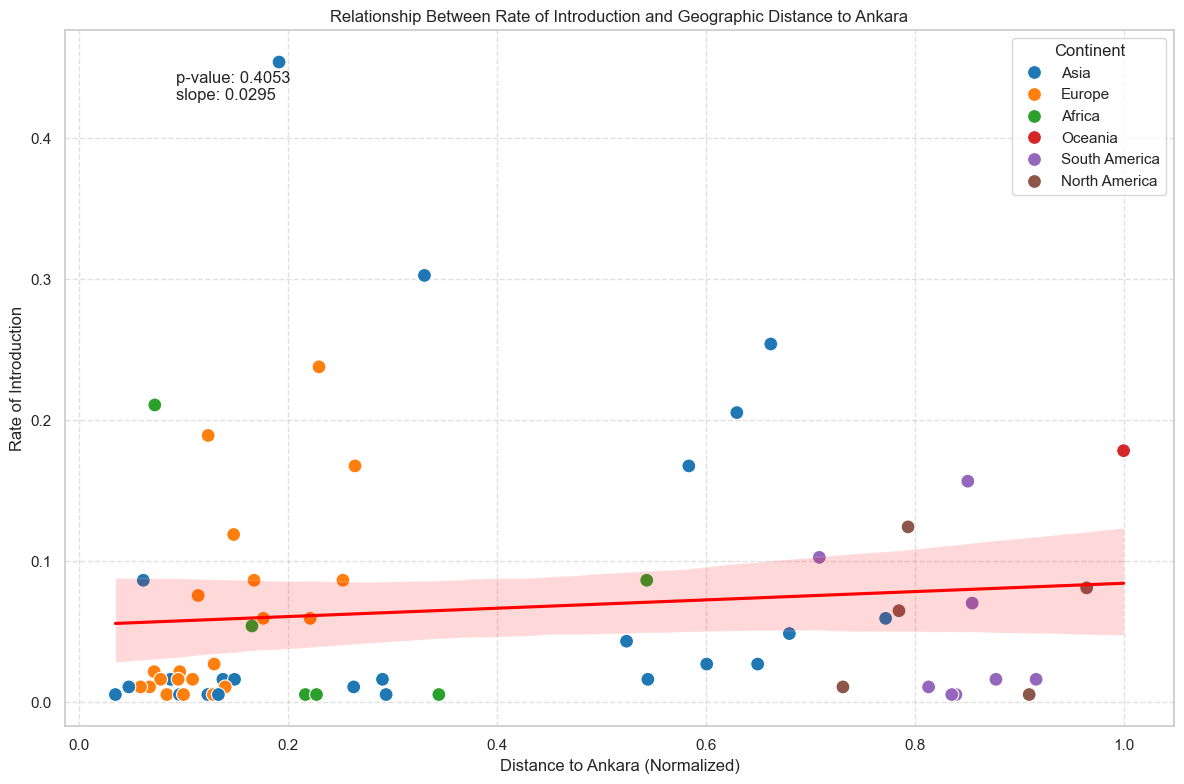

In [175]:
# now we measure the correlation between the rate of introduction and the geographic distance and cultural distance

#graph between rate of introduction and geographic distance
slope, intercept, r_value, p_value, std_err = linregress(country_data_merged_cultural_no_turkey['distance_to_ankara'], country_data_merged_cultural_no_turkey['rate of introduction'])
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='distance_to_ankara',
    y='rate of introduction',
    data=country_data_merged_cultural_no_turkey,
    hue='continent',
    palette='tab10',
    s=100,
    edgecolor='white'
)

# Add regression line without scatter points
sns.regplot(
    x='distance_to_ankara',
    y='rate of introduction',
    data=country_data_merged_cultural_no_turkey,
    scatter=False,
    color='red',
    line_kws={'label': f"Linear fit (p-value: {p_value:.4f}, Slope: {slope:.4f})"}
)

# Formatting the plot
plt.title('Relationship Between Rate of Introduction and Geographic Distance to Ankara')
plt.xlabel('Distance to Ankara (Normalized)')
plt.ylabel('Rate of Introduction')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.text(0.1, 0.9, f'p-value: {p_value:.4f}\nslope: {slope:.4f}', transform=plt.gca().transAxes)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()



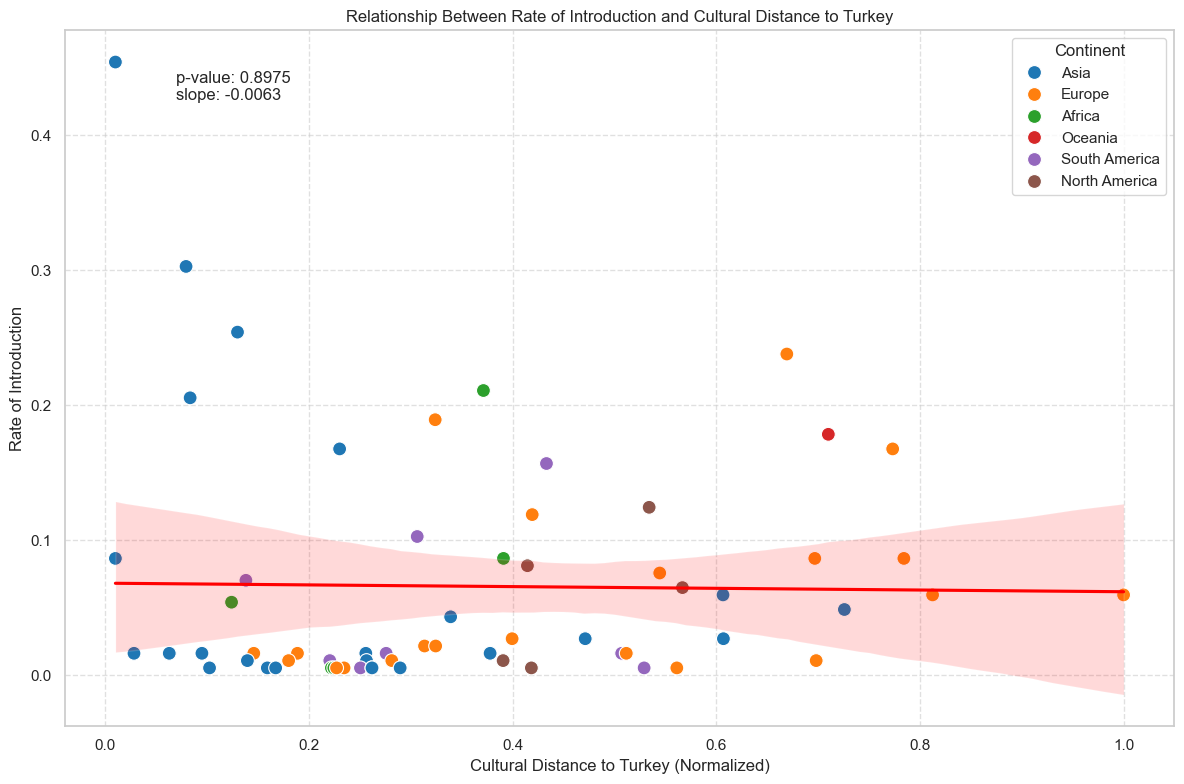

In [176]:
#graph between rate of introduction and cultural distance
slope, intercept, r_value, p_value, std_err = linregress(country_data_merged_cultural_no_turkey['cultural distance'], country_data_merged_cultural_no_turkey['rate of introduction'])
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='cultural distance',
    y='rate of introduction',
    data=country_data_merged_cultural_no_turkey,
    hue='continent',
    palette='tab10',
    s=100,
    edgecolor='white'
)

# Add regression line without scatter points
sns.regplot(
    x='cultural distance',
    y='rate of introduction',
    data=country_data_merged_cultural_no_turkey,
    scatter=False,
    color='red',
    line_kws={'label': f"Linear fit (p-value: {p_value:.4f}, Slope: {slope:.4f})"}
)

# Formatting the plot
plt.title('Relationship Between Rate of Introduction and Cultural Distance to Turkey')
plt.xlabel('Cultural Distance to Turkey (Normalized)')
plt.ylabel('Rate of Introduction')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.text(0.1, 0.9, f'p-value: {p_value:.4f}\nslope: {slope:.4f}', transform=plt.gca().transAxes)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()

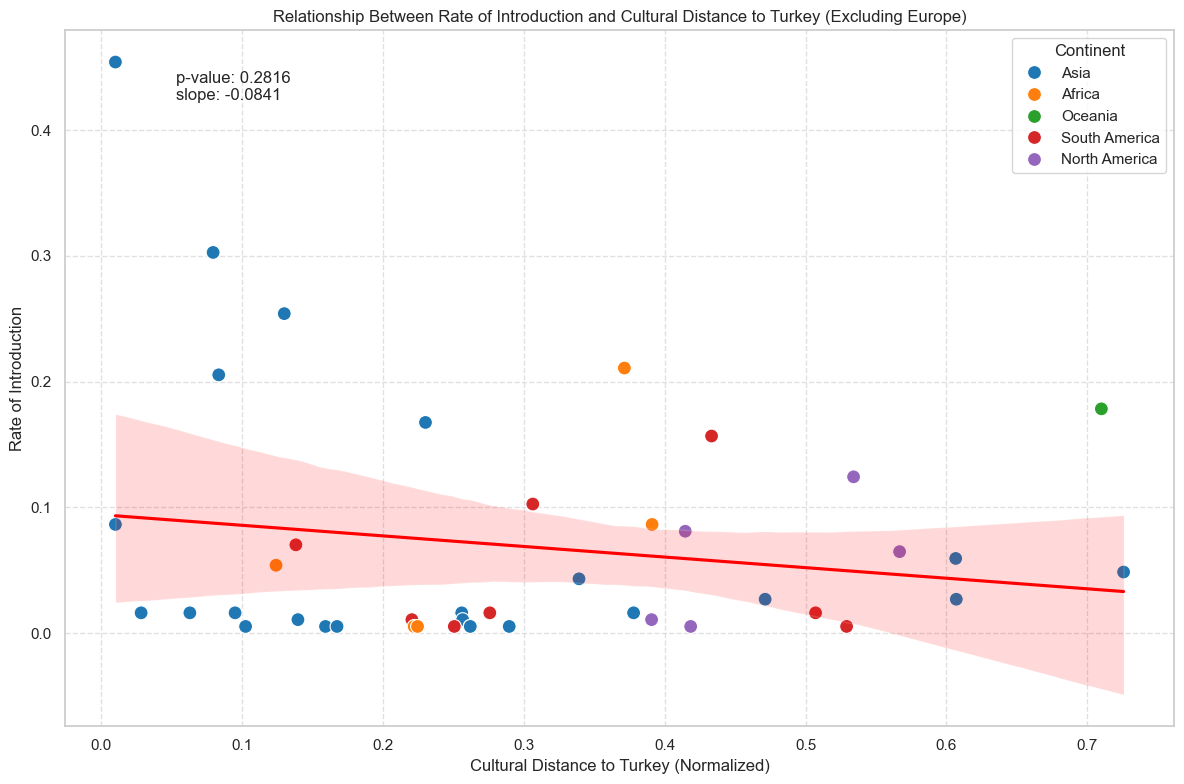

In [178]:
# drop the european countries
country_data_merged_cultural_no_turkey_no_europe = country_data_merged_cultural_no_turkey[country_data_merged_cultural_no_turkey['continent'] != 'Europe']
# plot the relationship between rate of introduction and cultural distance
slope, intercept, r_value, p_value, std_err = linregress(country_data_merged_cultural_no_turkey_no_europe['cultural distance'], country_data_merged_cultural_no_turkey_no_europe['rate of introduction'])

plt.figure(figsize=(12, 8))
# Scatter plot with points colored by continent
sns.scatterplot(
    x='cultural distance',
    y='rate of introduction',
    data=country_data_merged_cultural_no_turkey_no_europe,
    hue='continent',
    palette='tab10',
    s=100,
    edgecolor='white'
)

# Add regression line without scatter points
sns.regplot(
    x='cultural distance',
    y='rate of introduction',
    data=country_data_merged_cultural_no_turkey_no_europe,
    scatter=False,
    color='red',
    line_kws={'label': f"Linear fit (p-value: {p_value:.4f}, Slope: {slope:.4f})"}
)

# Formatting the plot
plt.title('Relationship Between Rate of Introduction and Cultural Distance to Turkey (Excluding Europe)')
plt.xlabel('Cultural Distance to Turkey (Normalized)')
plt.ylabel('Rate of Introduction')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.text(0.1, 0.9, f'p-value: {p_value:.4f}\nslope: {slope:.4f}', transform=plt.gca().transAxes)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()


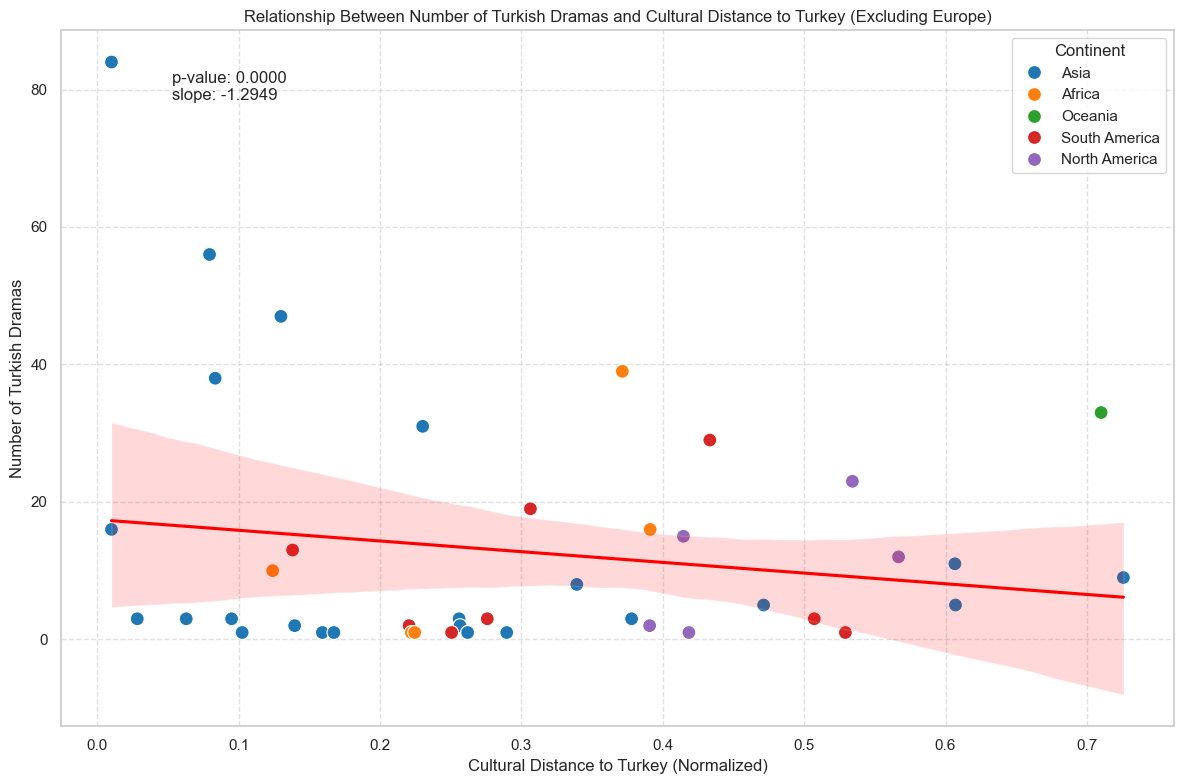

In [179]:
# Poisson for the relationship between number of Turkish dramas and cultural distance for non-European countries
poisson_model = sm.GLM(country_data_merged_cultural_no_turkey_no_europe['number of Turkish dramas'], sm.add_constant(country_data_merged_cultural_no_turkey_no_europe['cultural distance']), family=sm.families.Poisson()).fit()
slope = poisson_model.params['cultural distance']
p_value = poisson_model.pvalues['cultural distance']

# Plot the scatter plot and the regression line
plt.figure(figsize=(12, 8))
# Scatter plot with points colored by continent
sns.scatterplot(
    x='cultural distance',
    y='number of Turkish dramas',
    data=country_data_merged_cultural_no_turkey_no_europe,
    hue='continent',
    palette='tab10',
    s=100,
    edgecolor='white'
)

# Add regression line without scatter points
sns.regplot(
    x='cultural distance',
    y='number of Turkish dramas',
    data=country_data_merged_cultural_no_turkey_no_europe,
    scatter=False,
    color='red',
    line_kws={'label': f"Linear fit (p-value: {p_value:.4f}, Slope: {slope:.4f})"}
)

# Formatting the plot
plt.title('Relationship Between Number of Turkish Dramas and Cultural Distance to Turkey (Excluding Europe)')
plt.xlabel('Cultural Distance to Turkey (Normalized)')
plt.ylabel('Number of Turkish Dramas')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.text(0.1, 0.9, f'p-value: {p_value:.4f}\nslope: {slope:.4f}', transform=plt.gca().transAxes)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()


## Multivariate Regression

We then perform the multivariate regression between the dependent variable (number of dramas and rate of introduction) and the independent variables (geographic and cultural distance) to check if it will become significant if we control the partial effect of one variable.

In [180]:
# dependent variable: number of Turkish dramas; independent variables: cultural distance, geographic distance, and continent
data_for_analysis = pd.get_dummies(country_data_merged_cultural_no_turkey, columns=['continent'], drop_first=True)
data_for_analysis.head()




,country,number of Turkish dramas,Capital City,Latitude,Longitude,Population,Capital Type,distance_to_ankara,cultural distance,rate of introduction,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America
1,United Arab Emirates,84,Abu Zaby (Abu Dhabi),24.4648,54.3618,1419699,Capital,0.191260,0.010000,0.454054,True,False,False,False,False
2,India,56,Delhi,28.6667,77.2167,28513682,Capital,0.330512,0.079372,0.302703,True,False,False,False,False
3,Philippines,47,Manila,14.6042,120.9822,13482468,Capital,0.662158,0.129889,0.254054,True,False,False,False,False
4,France,44,Paris,48.8534,2.3488,10900952,Capital,0.229549,0.669318,0.237838,False,True,False,False,False
5,Egypt,39,Al-Qahirah (Cairo),30.0392,31.2394,20076002,Capital,0.072301,0.371383,0.210811,False,False,False,False,False


In [181]:
# change the dummies into numpy arrays
X = data_for_analysis[['cultural distance', 'distance_to_ankara', 'continent_Asia',  'continent_North America', 'continent_South America', 'continent_Oceania']].astype(float)


# Dependent variable
y = data_for_analysis['number of Turkish dramas']

# Add a constant to the independent variables
X = sm.add_constant(X)
# Fit the OLS model
model1 = sm.OLS(y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     number of Turkish dramas   R-squared:                       0.082
Model:                                  OLS   Adj. R-squared:                 -0.013
Method:                       Least Squares   F-statistic:                    0.8595
Date:                      Sat, 30 Nov 2024   Prob (F-statistic):              0.530
Time:                              15:37:51   Log-Likelihood:                -269.82
No. Observations:                        65   AIC:                             553.6
Df Residuals:                            58   BIC:                             568.9
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      10.6984      5.371      1.992      0.051      -0.053      21.449
cultural distance          -7.8698     11.171     -0.704      0.484     -30.231      14.492
distance_to_ankara         21.3531     13.656      1.564      0.123      -5.983      48.689
continent_Asia             -1.6181      6.021     -0.269      0.789     -13.669      10.433
continent_North America   -14.3077     12.028     -1.190      0.239     -38.384       9.769
continent_South America   -17.0799     11.722     -1.457      0.150     -40.544       6.384
continent_Oceania           6.5367     19.622      0.333      0.740     -32.742      45.815
==============================================================================
Omnibus:                       45.189   Durbin-Watson:                   0.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.315
Skew:                           2.164   Prob(JB):                     3.40e-31
Kurtosis:                       8.751   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
# Since numbers of Turkish dramas are counted outcomes, the better model is the Poisson regression model
# Fit the Poisson regression model
model2 = sm.GLM(y, X, family=sm.families.Poisson()).fit()
model2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     number of Turkish dramas   No. Observations:                   65
Model:                                  GLM   Df Residuals:                       58
Model Family:                       Poisson   Df Model:                            6
Link Function:                          Log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -597.18
Date:                      Sat, 30 Nov 2024   Deviance:                       961.72
Time:                              15:37:55   Pearson chi2:                 1.26e+03
No. Iterations:                           5   Pseudo R-squ. (CS):             0.7692
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.3868      0.094     25.489      0.000       2.203       2.570
cultural distance          -0.6494      0.199     -3.257      0.001      -1.040      -0.259
distance_to_ankara          1.5394      0.221      6.962      0.000       1.106       1.973
continent_Asia             -0.1318      0.106     -1.246      0.213      -0.339       0.076
continent_North America    -1.0243      0.208     -4.935      0.000      -1.431      -0.617
continent_South America    -1.2815      0.203     -6.316      0.000      -1.679      -0.884
continent_Oceania           0.0315      0.247      0.127      0.899      -0.453       0.516
===========================================================================================
"""

In [183]:
# model for only cultural distance
X = data_for_analysis[['cultural distance']].astype(float)
X = sm.add_constant(X)
model3 = sm.GLM(y, X, family=sm.families.Poisson()).fit()
model3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     number of Turkish dramas   No. Observations:                   65
Model:                                  GLM   Df Residuals:                       63
Model Family:                       Poisson   Df Model:                            1
Link Function:                          Log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -644.64
Date:                      Sat, 30 Nov 2024   Deviance:                       1056.6
Time:                              15:37:57   Pearson chi2:                 1.35e+03
No. Iterations:                           5   Pseudo R-squ. (CS):           0.005606
Covariance Type:                  nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.5346      0.067     37.866      0.000       2.403       2.666
cultural distance    -0.0967      0.160     -0.603      0.546      -0.411       0.217
=====================================================================================
"""

In [184]:
# model for only geographic distance
X = data_for_analysis[['distance_to_ankara']].astype(float)
X = sm.add_constant(X)
model4 = sm.GLM(y, X, family=sm.families.Poisson()).fit()
model4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     number of Turkish dramas   No. Observations:                   65
Model:                                  GLM   Df Residuals:                       63
Model Family:                       Poisson   Df Model:                            1
Link Function:                          Log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -637.46
Date:                      Sat, 30 Nov 2024   Deviance:                       1042.3
Time:                              15:37:59   Pearson chi2:                 1.40e+03
No. Iterations:                           5   Pseudo R-squ. (CS):             0.2027
Covariance Type:                  nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3297      0.058     39.877      0.000       2.215       2.444
distance_to_ankara     0.4317      0.111      3.877      0.000       0.213       0.650
======================================================================================
"""

As can be seen from the results, only after controlling continent and distance to Ankara, the effect of cultural distance to Turkey would be close to the significant level. 

## Sentiment Analysis

Our next job is to analyze the sentiment of the dramas and discuss which types of dramas are more likely to diffuse to another country. 

We go back to the original files to have the synopsis of the dramas. However, in the original data file, the synopsis is somehow truncated. Hence, we go back to the dramas website on turkishdramas.com and extract the complete synopsis. 


In [ ]:
import pandas as pd 
sentiment = pd.read_csv('final.csv')

from bs4 import BeautifulSoup

def extract_synopsis(url):
    # Fetch the HTML content of the page
    response = requests.get(url)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')

    # Initialize variables
    synopsis_content = []
    current_element = None

    # Try to find the <h2><strong>Synopsis</strong></h2> structure
    synopsis_heading = soup.find('h2', string=lambda text: text and 'Synopsis' in text)
    if synopsis_heading:
        # Collect all siblings until the next <h2> tag
        current_element = synopsis_heading.find_next_sibling()
    elif not synopsis_heading:
        # Try to find the <p><strong>Synopsis</strong>... structure
        synopsis_paragraph = soup.find('p')
        while synopsis_paragraph:
            strong_tag = synopsis_paragraph.find('strong')
            if strong_tag and 'Synopsis' in strong_tag.get_text():
                # Found the synopsis paragraph
                synopsis_content.append(synopsis_paragraph)
                current_element = synopsis_paragraph.find_next_sibling()
                break
            synopsis_paragraph = synopsis_paragraph.find_next('p')
        else:
            # Try to find the <p><u>Synopsis</u>... structure
            synopsis_paragraph = soup.find('p')
            while synopsis_paragraph:
                u_tag = synopsis_paragraph.find('u')
                if u_tag and 'Synopsis' in u_tag.get_text():
                    # Found the synopsis paragraph
                    synopsis_content.append(synopsis_paragraph)
                    current_element = synopsis_paragraph.find_next_sibling()
                    break
                synopsis_paragraph = synopsis_paragraph.find_next('p')
            else:
                # Try to find the <p><span style="text-decoration: underline;">Synopsis</span></p> structure
                synopsis_paragraph = soup.find('p')
                while synopsis_paragraph:
                    span_tag = synopsis_paragraph.find('span', style=lambda s: s and 'text-decoration: underline' in s)
                    if span_tag and 'Synopsis' in span_tag.get_text():
                        # Found the synopsis paragraph
                        synopsis_content.append(synopsis_paragraph)
                        current_element = synopsis_paragraph.find_next_sibling()
                        break
                    synopsis_paragraph = synopsis_paragraph.find_next('p')
                else:
                    return None  # Synopsis not found
    else:
        return None  # Synopsis not found

    # Collect all the elements until the next heading or end of content
    while current_element:
        if current_element.name == 'h2':
            break
        # Skip advertisements
        if current_element.name == 'div' and 'stream-item-in-post' in current_element.get('class', []):
            pass
        else:
            synopsis_content.append(current_element)
        current_element = current_element.find_next_sibling()

    # Extract text from the synopsis content
    synopsis_text = ''
    for element in synopsis_content:
        # Remove any ads inside the element
        for ad in element.find_all('div', class_='stream-item-in-post'):
            ad.decompose()
        synopsis_text += element.get_text(separator=' ', strip=True) + '\n'

    return synopsis_text.strip()
import pandas as pd
sentiment = pd.read_csv('final.csv')
sentiment['synopsis new'] = sentiment['URL'].apply(extract_synopsis)

# save the data first
sentiment.to_csv('final_with_synopsis.csv', index=False)
# check the missing data for synopsis new
sentiment['synopsis new'].isnull().sum()


Now we need to use ChatGPT to classify the sentiment flows of the dramas. Based on the dramaology theories, we call the flows as **"emotional arcs"**. A 2016 study (Reagan et al. 2016: https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-016-0093-1) analyzed thousands of stories using sentiment analysis to identify six core emotional arcs: <br>
Rags to Riches **(Rise)**: Steady emotional ascent. <br>

Riches to Rags **(Fall)**: Continuous emotional decline. <br>

Man in a Hole **(Fall–Rise)**: Fall followed by a rise. <br>

Icarus **(Rise–Fall)**: Rise leading to a fall. <br>

Cinderella **(Rise–Fall–Rise)**: Emotional rise, fall, and subsequent rise. <br>

Oedipus **(Fall–Rise–Fall)**: Emotional fall, rise, then fall again. <br>

We follow their classification and ask ChatGPT to classify the dramas in our dataset into these six categories.

In [ ]:
import pandas as pd
sentiment = pd.read_csv('final_with_synopsis.csv')
from openai import OpenAI
client = OpenAI()
def analyze_sentiment(text):
    # Prepare the messages for the ChatCompletion API
    messages = [
        {
            "role": "system",
            "content": "You are an assistant that classifies synopses into one of six emotional arcs."
        },
        {
            "role": "user",
            "content": f"""Please read the following synopsis of a drama and classify it into one of the six basic emotional arcs.

The six emotional arcs are:
- **Rise**: A steady emotional ascent throughout the story.
- **Fall**: A continuous emotional decline.
- **Fall–Rise**: A fall into misfortune followed by a rise to a better state.
- **Rise–Fall**: A rise to success or happiness that leads to a downfall.
- **Rise–Fall–Rise**: An emotional rise, then a fall, and a subsequent rise again.
- **Fall–Rise–Fall**: An emotional fall, followed by a rise, ending with another fall.

After reading the synopsis, please identify which of the six emotional arcs best fits the story. Here is the synopsis:

\"\"\"{text}\"\"\""""
        }
    ]
    
    # Call the OpenAI ChatCompletion API
    response = client.chat.completions.create(
        model="gpt-4",  # Use "gpt-3.5-turbo" if you don't have access to gpt-4
        messages=messages,
        max_tokens=50,
        temperature=0
    )
    
    # Extract the result
    sentiment = response.choices[0].message.content.strip()
    if '**Rise**' in sentiment:
        return 'Rise'
    elif '**Fall**' in sentiment:
        return 'Fall'
    elif '**Fall–Rise**' in sentiment:
        return 'Fall–Rise'
    elif '**Rise–Fall**' in sentiment:
        return 'Rise–Fall'
    elif '**Rise–Fall–Rise**' in sentiment:
        return 'Rise–Fall–Rise'
    elif '**Fall–Rise–Fall**' in sentiment:
        return 'Fall–Rise–Fall'
    else:
        return sentiment

# Analyze the sentiment of the synopses
sentiment['results'] = sentiment['synopsis new'].apply(analyze_sentiment)

#output the result file
sentiment.to_csv('final_with_sentiment.csv', index=False)

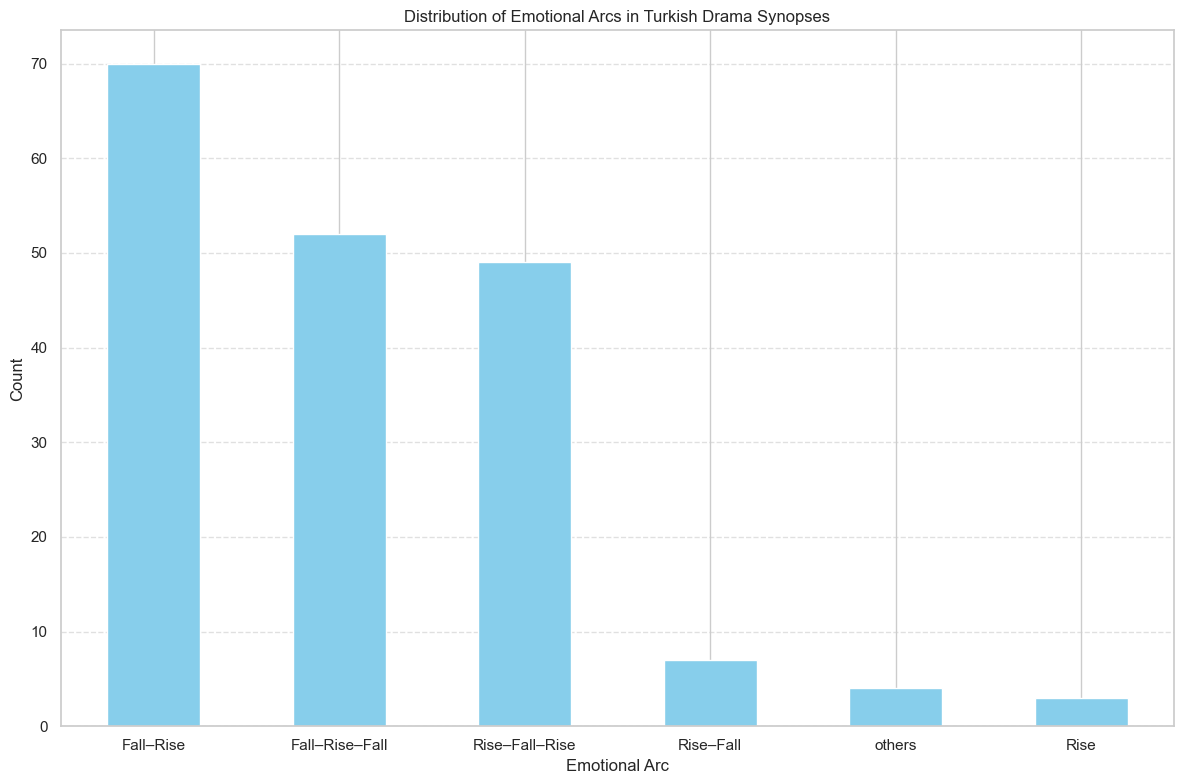

In [185]:
#get the distribution of the six emotional arcs
sentiment = pd.read_csv('final_with_sentiment.csv')
sentiment['results'].value_counts()
# reclean the sentiments:

def results_revise(results):
    if len(results) <=17:
        return results
    else:
        #check the results
        if '**Rise**' in results:
            return 'Rise'
        elif '**Fall**' in results:
            return 'Fall'
        elif '**Fall-Rise**' in results:
            return 'Fall–Rise'
        elif '**Rise–Fall**' in results:
            return 'Rise–Fall'
        elif '**Rise-Fall-Rise**' in results:
            return 'Rise–Fall–Rise'
        elif '**Fall–Rise–Fall**' in results:
            return 'Fall–Rise–Fall'
        else:
            return 'others'

sentiment['types'] = sentiment['results'].apply(results_revise)
sentiment['types'].value_counts()
# show the results in bar charts
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sentiment['types'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotional Arcs in Turkish Drama Synopses')
plt.xlabel('Emotional Arc')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Due to the distribution, we could classify the types into three categories: Fall-Rise; Fall-Rise-Fall; start with rise and others. We then use multinomial logistic analysis to identify which types are more likely to be introduced to specific countries. 

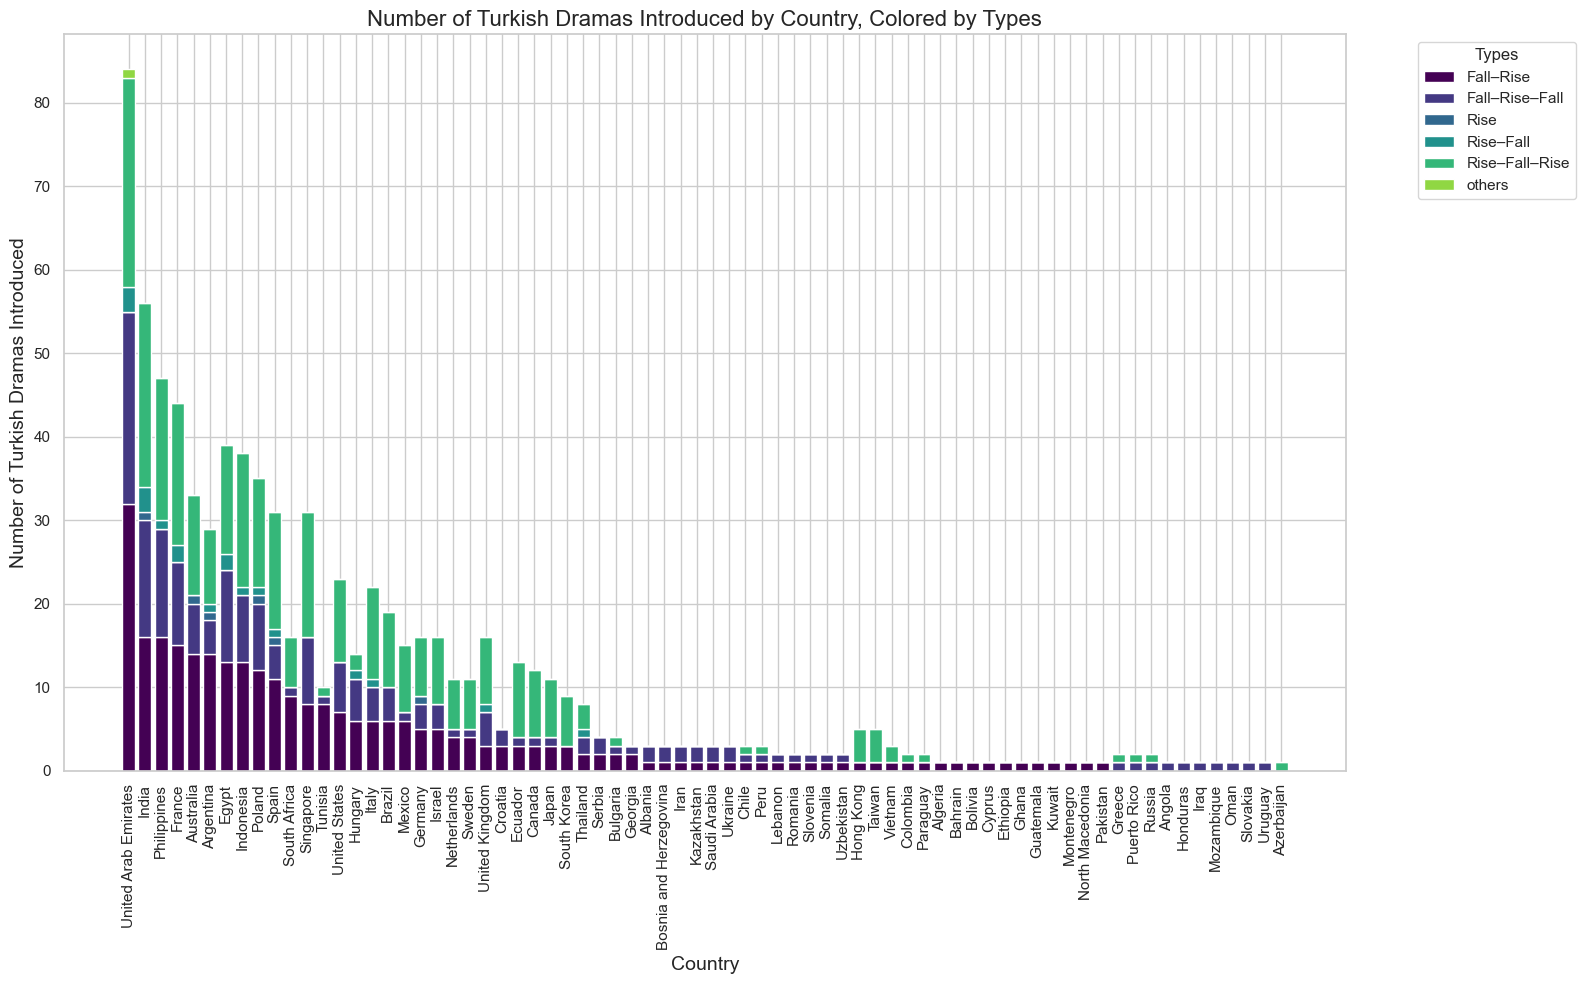

In [186]:
# plot number of Turkish dramas introduced by country, colored by types of emotional arcs
# transform the country type data into a long form

# we first need to clean the data (remove the duplicate countries and their dates)
country_cols = sorted([col for col in sentiment.columns if col.startswith('country')],
                        key=lambda x: int(x.replace('country', '')))
date_cols = sorted([col for col in sentiment.columns if col.startswith('date')],
                    key=lambda x: int(x.replace('date', '')))

# Function to process each row
def process_row(row):
    seen = set()
    for c_col, d_col in zip(country_cols, date_cols):
        country = row[c_col]
        if pd.isna(country):
            continue
        if country in seen:
            row[c_col] = None
            row[d_col] = None
        else:
            seen.add(country)
    return row

sentiment = sentiment.apply(process_row, axis=1)
# Identify Country and Date Columns
# Extract all columns that start with 'country' and 'date'
df = sentiment
# Identify Country and Date Columns
# Extract Indices from Column Names
# Ensure that countries and their corresponding dates are matched correctly
country_indices = [int(re.findall(r'\d+', col)[0]) for col in country_cols]
date_indices = [int(re.findall(r'\d+', col)[0]) for col in date_cols]

# Sort columns based on indices to align countries with their dates
country_cols = [x for _, x in sorted(zip(country_indices, country_cols))]
date_cols = [x for _, x in sorted(zip(date_indices, date_cols))]

# Melt the DataFrame to Long Format
# Transform the DataFrame from wide to long format for both countries and dates
id_vars = ['Original Title', 'types']
value_vars = country_cols + date_cols
long_df = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='variable', value_name='value')

# Extract variable type ('country' or 'date') and index number
long_df['variable_type'] = long_df['variable'].str.extract('([a-zA-Z]+)')
long_df['variable_index'] = long_df['variable'].str.extract('(\d+)')

# Pivot the DataFrame
# Reshape the DataFrame so each row corresponds to a country-date pair
long_df = long_df.pivot_table(
    index=id_vars + ['variable_index'],
    columns='variable_type',
    values='value',
    aggfunc='first'
).reset_index()

# Remove the columns name (which is set to 'variable_type' after pivot)
long_df.columns.name = None

# Clean the Data
# Remove rows with missing country information
long_df = long_df.dropna(subset=['country'])
long_df = long_df[long_df['country'] != 'Turkey']
# Optional: Clean up 'types' if necessary (e.g., remove leading/trailing whitespace)
long_df['types'] = long_df['types'].str.strip()

# Aggregate the Data
# Group by country and types to count the number of dramas
drama_counts = long_df.groupby(['country', 'types']).size().reset_index(name='counts')

# Pivot the Data for Stacked Bar Plot
# This will create a DataFrame where each row is a country and each column is a type
pivot_df = drama_counts.pivot(index='country', columns='types', values='counts').fillna(0)

# Sort the DataFrame for better visualization (optional)
pivot_df = pivot_df.sort_values(by=pivot_df.columns.tolist(), ascending=False)

# Plot the Data
# Set the figure size
plt.figure(figsize=(16, 10))

# Generate a list of types for consistent color mapping
types = pivot_df.columns.tolist()

# Generate a color palette
cmap = plt.get_cmap('viridis')
colors = [cmap(i / len(types)) for i in range(len(types))]

# Plot stacked bars
bottom = None
for idx, t in enumerate(types):
    if bottom is None:
        p = plt.bar(pivot_df.index, pivot_df[t], label=t, color=colors[idx])
        bottom = pivot_df[t]
    else:
        p = plt.bar(pivot_df.index, pivot_df[t], bottom=bottom, label=t, color=colors[idx])
        bottom += pivot_df[t]

# Customize the plot
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Turkish Dramas Introduced', fontsize=14)
plt.title('Number of Turkish Dramas Introduced by Country, Colored by Types', fontsize=16)
plt.xticks(rotation=90)
plt.legend(title='Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

We then apply the multinomial logisitc regression to analyze why compare to another type of drama, the country is more likely to introduce the specific type (dramas starting from a rise as the reference group).

In [187]:
# recategorize the types
recode_maps = {'Fall–Rise':1 , 'Fall–Rise–Fall': 2}
long_df['types_recode'] = long_df['types'].map(recode_maps).fillna(0).astype(int) #others and categories starting as rise are coded as 0

# multilogit regression 
# dependent variable: types_recode; independent variables: cultural distance, geographic distance, and continent
import statsmodels.api as sm

# data preparation
# transfer the wide-form sentiment data into long-form
long_df.head()


,Original Title,types,variable_index,country,date,types_recode
0,20 Dakika,Fall–Rise,1,Mexico,"January 1, 2013",1
2,20 Dakika,Fall–Rise,3,Hungary,"July 22, 2013",1
3,20 Dakika,Fall–Rise,6,Sweden,"January 13, 2014",1
4,20 Dakika,Fall–Rise,7,United Arab Emirates,"September 17, 2020",1
6,46 Yok Olan,Fall–Rise–Fall,2,Germany,"June 30, 2017",2


So in the dataset long_df, we have each row as a case for country-movie/drama. Hence, we can run the  multinominal regression on the types with features like continent (dummies), cultural distance, and distance to Ankara. 

In [188]:
import pycountry_convert as pc
import pycountry
def country_to_continent(country_name):
    try:
        # Lookup the country by name to get the alpha_2 code
        country = pycountry.countries.lookup(country_name)
        country_code = country.alpha_2
        # Map the alpha_2 code to a continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Convert the continent code to continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except Exception as e:
        # Handle exceptions (e.g., country not found)
        return None
long_df['continent'] = long_df['country'].apply(country_to_continent)
long_df.head()

,Original Title,types,variable_index,country,date,types_recode,continent
0,20 Dakika,Fall–Rise,1,Mexico,"January 1, 2013",1,North America
2,20 Dakika,Fall–Rise,3,Hungary,"July 22, 2013",1,Europe
3,20 Dakika,Fall–Rise,6,Sweden,"January 13, 2014",1,Europe
4,20 Dakika,Fall–Rise,7,United Arab Emirates,"September 17, 2020",1,Asia
6,46 Yok Olan,Fall–Rise–Fall,2,Germany,"June 30, 2017",2,Europe


In [189]:
# Now we can run the multinomial logistic regression
# Define the independent variables
# set continent as dummy variables
# merge the long_df with country_data_merged_cultural
country_data_merged_cultural = pd.read_csv('country_data_merged_cultural.csv')
long_df_merged = long_df.merge(country_data_merged_cultural[['country', 'cultural distance', 'distance_to_ankara']], on='country', how='left')
long_df_merged.head()
long_df_merged['types_recode'].value_counts()

types_recode
0    333
1    285
2    183
Name: count, dtype: int64

In [195]:

import statsmodels.api as sm
X = pd.get_dummies(long_df_merged['continent'], drop_first=True).astype(float)
X['cultural distance'] = long_df_merged['cultural distance']
X['distance_to_ankara'] = long_df_merged['distance_to_ankara']

# Dependent variable
y = long_df_merged['types_recode']

# Add a constant to the independent variables
X = sm.add_constant(X)

# check if there's any missing data for X and y
X.isnull().sum()

# save the data
#long_df_merged.to_csv('long_df_merged.csv', index=False)
# list the countries with missing data
missing_countries = long_df_merged[long_df_merged['cultural distance'].isnull()]['country'].unique()

missing_countries


array(['Bahrain', 'Somalia', 'Paraguay', 'Angola', 'Mozambique', 'Oman',
       'Honduras'], dtype=object)

we simply drop the countries.

In [196]:
# drop the missing data
long_df_merged = long_df_merged.dropna(subset=['cultural distance', 'distance_to_ankara'])
X = X.dropna()
y = long_df_merged['types_recode']


In [197]:

# Fit the Multinomial Logistic Regression Model
mlogit_model = sm.MNLogit(y, X).fit()
mlogit_model.summary()

Optimization terminated successfully.
         Current function value: 1.048937
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:           types_recode   No. Observations:                  792
Model:                        MNLogit   Df Residuals:                      776
Method:                           MLE   Df Model:                           14
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                 0.01752
Time:                        15:41:22   Log-Likelihood:                -830.76
converged:                       True   LL-Null:                       -845.57
Covariance Type:            nonrobust   LLR p-value:                  0.008580
======================================================================================
    types_recode=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8457      0.323      2.620      0.009       0.213       1.478
Asia                  -0.7654      0.361     -2.121      0.034      -1.473      -0.058
Europe                -0.2337      0.347     -0.674      0.500      -0.914       0.446
North America         -0.4298      0.530     -0.811      0.417      -1.468       0.609
Oceania                0.4158      0.622      0.668      0.504      -0.804       1.636
South America         -0.3453      0.516     -0.670      0.503      -1.356       0.665
cultural distance     -1.2308      0.559     -2.200      0.028      -2.327      -0.134
distance_to_ankara    -0.3135      0.579     -0.542      0.588      -1.447       0.820
--------------------------------------------------------------------------------------
    types_recode=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2880      0.394      0.730      0.465      -0.485       1.061
Asia                  -0.1211      0.437     -0.277      0.782      -0.978       0.735
Europe                 0.3245      0.414      0.783      0.433      -0.487       1.136
North America          0.4411      0.648      0.681      0.496      -0.829       1.711
Oceania                1.3022      0.768      1.695      0.090      -0.204       2.808
South America          0.2574      0.637      0.404      0.686      -0.990       1.505
cultural distance     -1.6269      0.660     -2.466      0.014      -2.920      -0.334
distance_to_ankara    -1.2081      0.664     -1.819      0.069      -2.510       0.094
======================================================================================
"""

The results show that if a country is more culturally distant or geographically distant to Turkey, compared to the more adjacent countries, they are less likely to introduce the dramas with the type "Fall-Rise", compared to the dramas starting with a rise. 

### Further Discussions

We may then further discuss if the likelihood of introducing specific types of dramas/movies is correlated with the countries similarities with Turkey in macro-socioeconomic situations of Turkey. We propose to measure the socioeconomic status with the following indecies: GDP, GDP growth rate, Inflation, Unempoyment rate, Gender parity, and Gini index. 